candidate id = 260806

# Introduction

Human activity recognition (HAR) is the process of identifying and classifying human movements and behaviours based on sensor data. It has various applications in healthcare, sports, and security, among others. In this project, we aim to develop a machine learning model to accurately detect human activity using sensor data.

The aim of the project is to build a system that determines duration of the activity performed by an individual and the type of activity performed by the individual. In order to do this, duration can be found by using the starting timestamp, ending timestamp and heartrate. This is easily possible with the given dataset as all records are provided with an activity ID that corresponds an activity such as: lying, walking, standing, running, etc. This activity ID helps to determine an activity session. Using this information, one can determine the duration of activity session with the help of start and end timestamps of the activity. For real time data, duration can be found with change in heartbeat, as will be shown further. Also, type of activity can be pedicted by various machine learning models using the columns provided in the dataset.


# Layout

The following layout of the report has been described below:
1.	Data Collection: The first and foremost step is data collection. Data collection is the method of collecting and computing information on variables of interest, in an established orderly fashion that helps us to answer research questions, test hypotheses, and evaluate results. Here, the dataset is provided to us and is called Physical Monitoring dataset and takes up about 1.21 Giga bytes of space.

2.	Data Manipulation: Data manipulation refers to the process of changing or modifying data in some way. This can involve a wide range of activities, including sorting data, summarizing data, merging data from different sources, performing calculations on data, and cleaning and formatting data. In our case, data manipulation starts while collecting data as activity records of each subject is stored in a separate files. Hence, these are merged along the rows to form a dataset. This will be described further in depth.

3.	EDA (Exploratory Data Analysis):  Exploratory data analysis is an approach to analysing and understanding data that is focused on discovering patterns, relationships, and trends in the data, rather than on confirmatory hypothesis testing or model fitting. The goal of EDA is to gain a better understanding of the data and to identify important features, patterns, and trends that may not be immediately apparent. Using the manipulated data, we perform a thorough data analysis and draw conclusions.

4.	Hypothesis Testing: Hypothesis testing is a statistical method used to test whether a hypothesis about a population is true or false. It involves formulating a hypothesis, collecting data, and evaluating the data to determine whether the hypothesis is supported or not.  This section contains two samples drawn from activities that are considered slow and activities that are considered fast. Therefore, using these two samples we reject/ fail to reject the design null hypothesis.

5.	Machine Learning: Machine learning is a way of data analysis that automates analytically building model. It is a subset of artificial intelligence that aims at building of computer programs that can have access to data and use it to learn for themselves. It is analogous to human learning, as is artificial intelligence to human intelligence. There are many different types of machine learning, including supervised learning, unsupervised learning, semi-supervised learning, and reinforcement learning. Supervised learning involves training a model on labelled data, where the correct output is provided for each example in the training set. Since, the dataset provided is labelled, we are going to follow supervised machine learning techniques.
Following are the sub steps performed in this section:
i)	Dimensionality Reduction
ii)	Modelling
iii)	Results
iv)	Discussion
6.	Conclusion: At last, we conclude about our proceedings with which ones turned out to be appropriate.


In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import warnings
import sklearn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

# 1.  Data Collection:

The data provided here contains 9 files for each subject in a .dat format. Files are named as subject101.dat, subject102.dat, and so on. These files do not contain column names, but description of the dataset describes what these columns are. Hence, we create a list containing all the columns in the same order mentioned in the description. Each subject has a sensor attached to their ankle, chest, and hand recording acceleration, gyroscope, and magnetometer data in 3 dimensions. Each of them also provides with orientation that is expressed in 4 values which in our case, is invalid. Temperature is also recorded by each sensor. We are also provided with ID and timestamp of each activity along with heartrate of individual during an activity. These are all the 54 columns provided to us in the dataset. Apart from this, new columns such as: activity and subject no.  are added to fill in labels of activities and subject numbers for each participating individual.

In order to read each file, we store the first file as a DataFrame and read succeeding file as another DataFrame and append it to the first one. We append all the following files to the first DataFrame and hence, eventually, form one DataFrame containing all records.


In [ ]:
# list that will contain all column names
columns = ['timestamp', 'activityID', 'heartrate']
IMUs = ['IMUhand', 'IMUchest', 'IMUankle']
sensors = ['acc16', 'acc6', 'gyro', 'mag']
axes = ['X','Y','Z']
orientations = ['orient1', 'orient2', 'orient3', 'orient4']
extra = ['subject no.', 'activity']

# appending all column names to the list
# using for loops as names follow a pattern
for IMU in IMUs:
  columns.append(IMU+'_'+'temperature')
  for sensor in sensors:
    for axis in axes:
      columns.append(IMU+'_'+sensor+axis)
  for orientation in orientations:
    columns.append(IMU+'_'+orientation)
columns.extend(extra)


In [ ]:
# all 54 columns + 2 extra columns
len(columns)

56

In [ ]:
# reading data of first subject
df = pd.read_csv("subject101.dat", delim_whitespace=True, names=columns)
# filling column with respective subject number
df['subject no.'] = [1]*len(df)
# iterating over rest of the subject files
for i in range(2, 10):
  # reading file
  filePath = "subject10"+str(i)+".dat"
  df2 = pd.read_csv(filePath, delim_whitespace=True, names=columns)#
  # filling column with respective subject number
  df2['subject no.'] = [i]*len(df2)
  # appending this dataframe to first dataframe df 
  df = df.append(df2, ignore_index=True)

In [ ]:
df['subject no.'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# dictionary mapping activity ID to activity label
activityDict = {
    '0': 'Other',
    '1': 'Lying',
    '2': 'Sitting',
    '3': 'Standing',
    '4': 'Walking',
    '5': 'Running',
    '6': 'Cycling',
    '7': 'Nordic Walking',
    '9': 'Watching TV',
    '10': 'Computer work',
    '11': 'Car driving',
    '12': 'Ascending stairs',
    '13': 'Descending stairs',
    '16': 'Vacuum cleaning',
    '17': 'Ironing',
    '18': 'Folding laundry',
    '19': 'House cleaning',
    '20': 'Playing soccer',
    '24': 'Rope jumping'
}

In [ ]:
# empty list to store labels of activities
#  for each record in the dataset
activityList = []
for i in range(len(df)):
  activityList.append(activityDict[str(df['activityID'][i])])

In [ ]:
# assigning activity list to the column
df['activity'] = activityList

In [ ]:
df['activityID'].unique()

array([ 0,  1,  2,  3, 17, 16, 12, 13,  4,  7,  6,  5, 24])

In [ ]:
# different types of activities in the column
df['activity'].unique()

array(['Other', 'Lying', 'Sitting', 'Standing', 'Ironing',
       'Vacuum cleaning', 'Ascending stairs', 'Descending stairs',
       'Walking', 'Nordic Walking', 'Cycling', 'Running', 'Rope jumping'],
      dtype=object)

In [ ]:
df

,timestamp,activityID,heartrate,IMUhand_temperature,IMUhand_acc16X,IMUhand_acc16Y,IMUhand_acc16Z,IMUhand_acc6X,IMUhand_acc6Y,IMUhand_acc6Z,...,IMUankle_gyroZ,IMUankle_magX,IMUankle_magY,IMUankle_magZ,IMUankle_orient1,IMUankle_orient2,IMUankle_orient3,IMUankle_orient4,subject no.,activity
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,1,Other
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,1,Other
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,1,Other
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,1,Other
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,1,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,9,Other
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,9,Other
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,9,Other
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029208,9,Other


In [ ]:
# checking for null values
df.isnull().sum()

timestamp                     0
activityID                    0
heartrate               2610265
IMUhand_temperature       13141
IMUhand_acc16X            13141
IMUhand_acc16Y            13141
IMUhand_acc16Z            13141
IMUhand_acc6X             13141
IMUhand_acc6Y             13141
IMUhand_acc6Z             13141
IMUhand_gyroX             13141
IMUhand_gyroY             13141
IMUhand_gyroZ             13141
IMUhand_magX              13141
IMUhand_magY              13141
IMUhand_magZ              13141
IMUhand_orient1           13141
IMUhand_orient2           13141
IMUhand_orient3           13141
IMUhand_orient4           13141
IMUchest_temperature       3563
IMUchest_acc16X            3563
IMUchest_acc16Y            3563
IMUchest_acc16Z            3563
IMUchest_acc6X             3563
IMUchest_acc6Y             3563
IMUchest_acc6Z             3563
IMUchest_gyroX             3563
IMUchest_gyroY             3563
IMUchest_gyroZ             3563
IMUchest_magX              3563
IMUchest

# 2. Data Manipulation

Moving on, we come across columns that are invalid or unnecessary according to the description so, we drop those columns. After dropping columns, we split the DataFrame into training and test set. Now, the goal is to get session indices for the training dataset. To do so, we create a function that returns a list of containing tuple of indices. Using these indices, we can find duration of each activity session as well as fill null values with mean of the column for that specific activity session. We achieve this using three main functions as follows:

	def getSessionIndices(dataset):  This function takes in a dataset and returns a   list containing tuple of indices. Each tuple contains a starting index and ending index of each session. These indices are determined when change in activity ID occurs. A session refers to an activity done by an individual for a particular time. These indices help to determine the duration of an activity.

	def fillNullWithMean(dataset, indices): This function takes in a dataset and its activity session indices and uses them to replace null values with mean of the column for that session. It returns nothing as all the changes are made directly to the DataFrame.

	def createDurationDataset(dataset, indices): This function takes in a dataset and its session indices and returns a new DataFrame containing duration of each activity. Duration is found using difference of values at end and start indices of timestamp column. This function fits rows of a session into one row. This one row contains average values of each column for that session.

We create a new DataFrame with the training set using the functions above that contains the duration of each activity and drop all activities with activity ID = 0 and rows with null values. We use training set and duration training set in exploratory data analysis.


In [ ]:
# dropping columns that are invalid/ unnecessary as per description
removeCols = ['IMUhand_acc6X', 'IMUhand_acc6Y', 'IMUhand_acc6Z', 'IMUchest_acc6X', 'IMUchest_acc6Y', 'IMUchest_acc6Z', 
              'IMUankle_acc6X', 'IMUankle_acc6Y', 'IMUankle_acc6Z', 'IMUhand_orient1', 'IMUhand_orient2', 'IMUhand_orient3',
              'IMUhand_orient4', 'IMUchest_orient1', 'IMUchest_orient2', 'IMUchest_orient3', 'IMUchest_orient4', 'IMUankle_orient1',
              'IMUankle_orient2', 'IMUankle_orient3', 'IMUankle_orient4']
df.drop(columns = removeCols, inplace=True)
df

,timestamp,activityID,heartrate,IMUhand_temperature,IMUhand_acc16X,IMUhand_acc16Y,IMUhand_acc16Z,IMUhand_gyroX,IMUhand_gyroY,IMUhand_gyroZ,...,IMUankle_acc16Y,IMUankle_acc16Z,IMUankle_gyroX,IMUankle_gyroY,IMUankle_gyroZ,IMUankle_magX,IMUankle_magY,IMUankle_magZ,subject no.,activity
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,-0.092217,0.056812,-0.015845,...,-1.655690,-0.099797,0.008300,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1,Other
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,-0.024413,0.047759,0.006474,...,-1.579020,-0.215687,-0.006577,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1,Other
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,-0.057976,0.032574,-0.006988,...,-1.732760,0.092914,0.003014,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1,Other
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,-0.002352,0.032810,-0.003747,...,-1.770400,0.054545,0.003175,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1,Other
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,0.012269,0.018305,-0.053325,...,-1.656250,-0.060809,0.012698,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2872528,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,1.784060,0.087985,0.934673,...,-0.565040,-3.273700,-0.037788,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,9,Other
2872529,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,1.475210,-0.028917,0.806540,...,-1.020820,-3.308730,-0.068904,-0.027006,-0.089808,-45.7474,3.54453,0.108583,9,Other
2872530,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,1.290990,-0.155493,0.762446,...,-0.528578,-3.233400,-0.070888,-0.038024,-0.064709,-46.3997,4.22078,0.105504,9,Other
2872531,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,1.207940,-0.311214,0.748814,...,-0.489493,-3.311610,0.018961,-0.025796,-0.064357,-46.5282,4.48593,0.530240,9,Other


In [ ]:
X = df 
y = df['activity']

# splitting dataset into training and testing 
X_train, X_test, _, _ = train_test_split(X, y, test_size=0.30, random_state=42)
# sorting to nullify shuffling
X_train.sort_index(inplace=True)
# resetting index
X_train.reset_index(inplace=True, drop=True)

X_test.sort_index(inplace=True)
X_test.reset_index(inplace=True, drop=True)

In [ ]:
X_train

,timestamp,activityID,heartrate,IMUhand_temperature,IMUhand_acc16X,IMUhand_acc16Y,IMUhand_acc16Z,IMUhand_gyroX,IMUhand_gyroY,IMUhand_gyroZ,...,IMUankle_acc16Y,IMUankle_acc16Z,IMUankle_gyroX,IMUankle_gyroY,IMUankle_gyroZ,IMUankle_magX,IMUankle_magY,IMUankle_magZ,subject no.,activity
0,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,-0.057976,0.032574,-0.006988,...,-1.732760,0.092914,0.003014,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1,Other
1,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,-0.002352,0.032810,-0.003747,...,-1.770400,0.054545,0.003175,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1,Other
2,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,0.012269,0.018305,-0.053325,...,-1.656250,-0.060809,0.012698,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1,Other
3,8.44,0,NaN,30.0000,2.33738,8.82900,3.54767,-0.023704,-0.031518,-0.047883,...,-1.732420,-0.059956,-0.031973,-0.053934,0.015594,-60.6307,-38.86760,-58.271100,1,Other
4,8.45,0,NaN,30.0000,2.37142,9.05500,3.39347,0.019069,-0.022004,-0.033647,...,-1.619560,0.093369,-0.019643,-0.039937,-0.000785,-60.5171,-38.98190,-58.273300,1,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010768,100.15,0,NaN,25.1875,-4.88664,8.24912,4.48058,1.327620,0.362557,1.203300,...,-1.093580,-3.998870,-0.119020,-0.016952,-0.148926,-46.3962,4.35102,0.672693,9,Other
2010769,100.17,0,NaN,25.1875,-4.92285,9.42385,4.28364,1.795150,0.262719,1.105910,...,-0.525886,-3.275860,-0.052588,0.009088,-0.150870,-46.0219,4.45943,0.106556,9,Other
2010770,100.18,0,NaN,25.1875,-4.99389,9.88004,4.31952,1.868770,0.139438,1.016820,...,-0.035269,-2.893250,-0.045662,0.011414,-0.139014,-46.0153,4.07245,-0.034804,9,Other
2010771,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,1.290990,-0.155493,0.762446,...,-0.528578,-3.233400,-0.070888,-0.038024,-0.064709,-46.3997,4.22078,0.105504,9,Other


In [ ]:
X_test

,timestamp,activityID,heartrate,IMUhand_temperature,IMUhand_acc16X,IMUhand_acc16Y,IMUhand_acc16Z,IMUhand_gyroX,IMUhand_gyroY,IMUhand_gyroZ,...,IMUankle_acc16Y,IMUankle_acc16Z,IMUankle_gyroX,IMUankle_gyroY,IMUankle_gyroZ,IMUankle_magX,IMUankle_magY,IMUankle_magZ,subject no.,activity
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,-0.092217,0.056812,-0.015845,...,-1.655690,-0.099797,0.008300,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1,Other
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,-0.024413,0.047759,0.006474,...,-1.579020,-0.215687,-0.006577,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1,Other
2,8.43,0,NaN,30.0000,2.29959,8.82929,3.54710,0.003238,0.012260,-0.054474,...,-1.655600,-0.138014,-0.006089,-0.016024,0.001050,-60.2954,-38.87780,-58.397700,1,Other
3,8.47,0,NaN,30.0000,2.25966,9.09415,3.43015,0.007627,-0.057759,-0.019075,...,-1.656800,-0.021820,0.007649,-0.013923,0.014498,-60.8509,-39.08210,-58.147800,1,Other
4,8.49,0,NaN,30.0000,2.29531,8.79035,3.43171,-0.013998,-0.040875,-0.029675,...,-1.656250,-0.060809,0.060176,0.004388,0.003780,-60.6221,-39.20530,-57.779700,1,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861755,100.14,0,NaN,25.1875,-4.88076,8.32634,4.63435,1.097760,0.488410,1.213550,...,-0.755258,-3.424240,-0.070663,-0.129196,-0.149063,-46.5344,5.00248,0.955115,9,Other
861756,100.16,0,NaN,25.1875,-4.81963,8.73872,4.13354,1.565220,0.294202,1.180800,...,-0.942279,-3.846550,-0.025073,-0.012637,-0.117128,-46.0262,4.58797,-0.035441,9,Other
861757,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,1.784060,0.087985,0.934673,...,-0.565040,-3.273700,-0.037788,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,9,Other
861758,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,1.475210,-0.028917,0.806540,...,-1.020820,-3.308730,-0.068904,-0.027006,-0.089808,-45.7474,3.54453,0.108583,9,Other


In [ ]:
X_train.isnull().sum()

timestamp                     0
activityID                    0
heartrate               1827077
IMUhand_temperature        9194
IMUhand_acc16X             9194
IMUhand_acc16Y             9194
IMUhand_acc16Z             9194
IMUhand_gyroX              9194
IMUhand_gyroY              9194
IMUhand_gyroZ              9194
IMUhand_magX               9194
IMUhand_magY               9194
IMUhand_magZ               9194
IMUchest_temperature       2470
IMUchest_acc16X            2470
IMUchest_acc16Y            2470
IMUchest_acc16Z            2470
IMUchest_gyroX             2470
IMUchest_gyroY             2470
IMUchest_gyroZ             2470
IMUchest_magX              2470
IMUchest_magY              2470
IMUchest_magZ              2470
IMUankle_temperature       8221
IMUankle_acc16X            8221
IMUankle_acc16Y            8221
IMUankle_acc16Z            8221
IMUankle_gyroX             8221
IMUankle_gyroY             8221
IMUankle_gyroZ             8221
IMUankle_magX              8221
IMUankle

In [ ]:
def getSessionIndices(dataset):

  indices = []
  startIndex = 0
  # iterating using length of dataframe
  for i in range(len(dataset)+1):
    #print(i)
    # if i is last index
    if i == len(dataset)-1:
      # print(startIndex, i)
      # append indices
      indices.append((startIndex, len(dataset)))
      break
    # store current value
    currentValue = dataset['activityID'][i]
    # store next value
    nextValue = dataset['activityID'][i+1]
    # if change in activity ID 
    if currentValue != nextValue:
      # assign current i to end index variable
      endIndex = i
      #print(startIndex, endIndex)
      # append indices
      indices.append((startIndex, endIndex))
      # reset start index variable
      startIndex = i+1
  # return list
  return indices

In [ ]:
# all columns with null values
imputingColumns = ['heartrate','IMUhand_temperature','IMUhand_acc16X','IMUhand_acc16Y',
 'IMUhand_acc16Z','IMUhand_gyroX','IMUhand_gyroY','IMUhand_gyroZ','IMUhand_magX',
 'IMUhand_magY','IMUhand_magZ','IMUchest_temperature',
 'IMUchest_acc16X','IMUchest_acc16Y','IMUchest_acc16Z','IMUchest_gyroX',
 'IMUchest_gyroY','IMUchest_gyroZ','IMUchest_magX','IMUchest_magY','IMUchest_magZ','IMUankle_temperature','IMUankle_acc16X','IMUankle_acc16Y','IMUankle_acc16Z',
 'IMUankle_gyroX','IMUankle_gyroY','IMUankle_gyroZ','IMUankle_magX','IMUankle_magY','IMUankle_magZ'] 

#len(imputingColumns)

def fillNullWithMean(dataset, indices):

  # iterating over all empty columns
  for col in imputingColumns:
    for tup in indices:
      # getting starting and ending indices
      start, end = tup[0], tup[1]
      dataset[col][start:end+1].fillna(dataset[col][start:end+1].mean(), inplace=True)

In [ ]:
xTrainIndices = getSessionIndices(X_train)
fillNullWithMean(X_train, xTrainIndices)

In [ ]:
X_train.isnull().sum()

timestamp               0
activityID              0
heartrate               7
IMUhand_temperature     0
IMUhand_acc16X          0
IMUhand_acc16Y          0
IMUhand_acc16Z          0
IMUhand_gyroX           0
IMUhand_gyroY           0
IMUhand_gyroZ           0
IMUhand_magX            0
IMUhand_magY            0
IMUhand_magZ            0
IMUchest_temperature    0
IMUchest_acc16X         0
IMUchest_acc16Y         0
IMUchest_acc16Z         0
IMUchest_gyroX          0
IMUchest_gyroY          0
IMUchest_gyroZ          0
IMUchest_magX           0
IMUchest_magY           0
IMUchest_magZ           0
IMUankle_temperature    0
IMUankle_acc16X         0
IMUankle_acc16Y         0
IMUankle_acc16Z         0
IMUankle_gyroX          0
IMUankle_gyroY          0
IMUankle_gyroZ          0
IMUankle_magX           0
IMUankle_magY           0
IMUankle_magZ           0
subject no.             0
activity                0
dtype: int64

In [ ]:
# new columns for new dataframe
updatedCols = []
updatedCols.append('duration')
updatedCols.extend(df.columns[1:])
len(updatedCols)

def createDurationDataset(dataset, indices):

  # initialising new dataframe only with columns
  dfFinal = pd.DataFrame(columns=updatedCols)
  # this will become a nested list to form a dataframe
  data = []
  for i in range(len(indices)): 
    # list to store all values of a row
    record = []
    start, end = indices[i][0], indices[i][1]
    # finding duration and appending it to list
    record.append(max(df['timestamp'][start:end+1]) - min(df['timestamp'][start:end+1]))

    for col in updatedCols[1:]:
      if col == 'activity' :
        # store activity label as is
        record.append(df[col][start])
        continue
      if col == 'subject no.':
        # store subject number as is
        record.append(df[col][start])
        continue
      if col == 'activityID':
        # store activity ID as
        record.append(df[col][start])
        continue
      # store average of value for the column from start to end index
      record.append(np.nanmean(df[col][start:end+1].values))
    # forming a dataset using nested list
    data.append(record) 
  dfFinal = pd.DataFrame(data, columns=updatedCols)
  # return dataframe
  return dfFinal

In [ ]:
xTrainDuration = createDurationDataset(X_train, xTrainIndices)
# new dataframe with duration
xTrainDuration

,duration,activityID,heartrate,IMUhand_temperature,IMUhand_acc16X,IMUhand_acc16Y,IMUhand_acc16Z,IMUhand_gyroX,IMUhand_gyroY,IMUhand_gyroZ,...,IMUankle_acc16Y,IMUankle_acc16Z,IMUankle_gyroX,IMUankle_gyroY,IMUankle_gyroZ,IMUankle_magX,IMUankle_magY,IMUankle_magZ,subject no.,activity
0,20.70,0,101.547368,30.154424,2.338896,8.785441,3.666165,0.004991,0.003692,-0.005474,...,-1.721462,-0.035823,0.007333,-0.005460,0.004594,-60.808762,-38.218791,-58.159161,1,Other
1,192.13,0,90.467236,31.033226,3.371976,3.165339,2.613413,0.008689,-0.003489,-0.000502,...,-4.664748,-6.678798,0.003468,-0.003745,0.011459,-21.572387,30.277883,0.053465,1,Other
2,166.14,1,87.294931,31.888321,3.230531,4.776079,5.185067,0.013622,0.006903,-0.005884,...,-2.983505,-6.191219,-0.003720,-0.014891,-0.010100,-32.846971,12.831517,0.386420,1,Lying
3,152.28,2,90.181753,32.429210,-2.342156,6.452878,4.855071,-0.005598,0.001441,-0.016940,...,1.684429,-4.990975,0.007788,0.001530,0.000559,-72.850146,31.130299,28.739766,1,Sitting
4,67.29,2,105.689935,32.758011,-4.491235,5.725008,3.435826,0.021982,0.003405,-0.021514,...,-1.335041,-1.123875,-0.031777,-0.004062,0.005609,-78.323715,17.149956,27.015469,1,Sitting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,119.65,0,115.909506,33.375089,-8.364485,3.672724,1.711282,-0.258403,0.060678,0.010169,...,1.186902,-2.805404,0.216632,0.036044,-0.010683,-32.884513,-6.785930,10.402017,6,Other
191,61.27,13,143.875000,33.193223,-3.783401,3.546741,4.934808,-0.236872,-0.059549,-0.346808,...,1.810761,-2.201409,-0.207527,-0.280090,0.048265,-34.695176,-9.335837,15.338831,6,Descending stairs
192,148.84,0,125.926525,32.927421,-4.362597,5.047099,1.722760,-0.014760,-0.016581,-0.021091,...,0.887055,-2.226904,-0.051904,-0.039430,0.027814,-41.607985,3.022463,18.067490,6,Other
193,45.02,0,107.182039,32.738056,-6.184134,4.327227,2.880481,-0.051978,0.027391,-0.060922,...,1.278908,-2.262671,-0.046300,-0.034980,0.025864,-37.037189,-5.965641,13.129437,6,Other


In [ ]:
xTrainDuration.drop(xTrainDuration[xTrainDuration.activityID==0].index, inplace=True,)
xTrainDuration.reset_index(drop=True,inplace=True)
xTrainDuration.dropna(axis=0, inplace=True)

In [ ]:
xTrainDuration

,duration,activityID,heartrate,IMUhand_temperature,IMUhand_acc16X,IMUhand_acc16Y,IMUhand_acc16Z,IMUhand_gyroX,IMUhand_gyroY,IMUhand_gyroZ,...,IMUankle_acc16Y,IMUankle_acc16Z,IMUankle_gyroX,IMUankle_gyroY,IMUankle_gyroZ,IMUankle_magX,IMUankle_magY,IMUankle_magZ,subject no.,activity
0,166.14,1,87.294931,31.888321,3.230531,4.776079,5.185067,0.013622,0.006903,-0.005884,...,-2.983505,-6.191219,-0.003720,-0.014891,-0.010100,-32.846971,12.831517,0.386420,1,Lying
1,152.28,2,90.181753,32.429210,-2.342156,6.452878,4.855071,-0.005598,0.001441,-0.016940,...,1.684429,-4.990975,0.007788,0.001530,0.000559,-72.850146,31.130299,28.739766,1,Sitting
2,67.29,2,105.689935,32.758011,-4.491235,5.725008,3.435826,0.021982,0.003405,-0.021514,...,-1.335041,-1.123875,-0.031777,-0.004062,0.005609,-78.323715,17.149956,27.015469,1,Sitting
3,165.79,3,101.916777,33.021671,-3.630340,6.173462,2.889059,-0.017314,0.018924,-0.002000,...,-2.224847,-1.064029,0.026930,0.004868,0.006177,-79.873543,-8.921365,15.090551,1,Standing
4,87.67,17,101.187032,33.351970,-2.902852,5.630922,6.411810,-0.006904,0.010861,0.020582,...,-1.545262,-1.698897,0.009716,-0.001729,0.003481,-54.973320,-5.298558,49.198842,1,Ironing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,159.61,3,87.011652,33.801957,-2.965897,4.003792,6.495163,0.010112,0.002089,0.001834,...,-1.060763,-1.589763,0.006927,-0.004684,0.004382,-38.113785,11.660841,41.560950,6,Standing
129,220.93,17,87.658379,33.996301,-5.113714,4.863048,5.167311,0.020211,0.009630,0.007330,...,-0.648874,-2.179758,0.004088,-0.000750,0.002814,-32.894953,13.848761,41.706188,6,Ironing
130,159.54,17,84.717736,34.119259,-5.447997,3.559061,3.776923,0.033515,0.006326,0.011519,...,-0.026444,-2.590438,-0.021559,-0.009401,0.005240,-22.779832,2.193439,21.537297,6,Ironing
131,178.42,16,103.527027,34.061003,-7.847232,5.248025,0.698436,-0.005691,0.034826,0.010952,...,0.809242,-2.275722,-0.001384,-0.005894,0.013252,-25.708655,-0.759060,10.913645,6,Vacuum cleaning


In [ ]:
xTrainDuration.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 0 to 132
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   duration              132 non-null    float64
 1   activityID            132 non-null    int64  
 2   heartrate             132 non-null    float64
 3   IMUhand_temperature   132 non-null    float64
 4   IMUhand_acc16X        132 non-null    float64
 5   IMUhand_acc16Y        132 non-null    float64
 6   IMUhand_acc16Z        132 non-null    float64
 7   IMUhand_gyroX         132 non-null    float64
 8   IMUhand_gyroY         132 non-null    float64
 9   IMUhand_gyroZ         132 non-null    float64
 10  IMUhand_magX          132 non-null    float64
 11  IMUhand_magY          132 non-null    float64
 12  IMUhand_magZ          132 non-null    float64
 13  IMUchest_temperature  132 non-null    float64
 14  IMUchest_acc16X       132 non-null    float64
 15  IMUchest_acc16Y       1

In [ ]:
# removing all rows with activity ID = 0
X_train.drop(X_train[X_train.activityID==0].index, inplace=True)
X_train.dropna(inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360258 entries, 0 to 1360257
Data columns (total 35 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   timestamp             1360258 non-null  float64
 1   activityID            1360258 non-null  int64  
 2   heartrate             1360258 non-null  float64
 3   IMUhand_temperature   1360258 non-null  float64
 4   IMUhand_acc16X        1360258 non-null  float64
 5   IMUhand_acc16Y        1360258 non-null  float64
 6   IMUhand_acc16Z        1360258 non-null  float64
 7   IMUhand_gyroX         1360258 non-null  float64
 8   IMUhand_gyroY         1360258 non-null  float64
 9   IMUhand_gyroZ         1360258 non-null  float64
 10  IMUhand_magX          1360258 non-null  float64
 11  IMUhand_magY          1360258 non-null  float64
 12  IMUhand_magZ          1360258 non-null  float64
 13  IMUchest_temperature  1360258 non-null  float64
 14  IMUchest_acc16X       1360258 non-

In [ ]:
X_train['activityID'].unique()

array([ 1,  2,  3, 17, 16, 12, 13,  4,  7,  6,  5, 24])

# 3. EDA

## 3.1 What is the frequency plot of each activity?

We begin with visualizing the frequency of all activity classes from the entire dataset as well as from the training set. We see there are unequal frequencies of each activity in both, the entire dataset as well as the training set. 

Text(0, 0.5, 'Frequency')

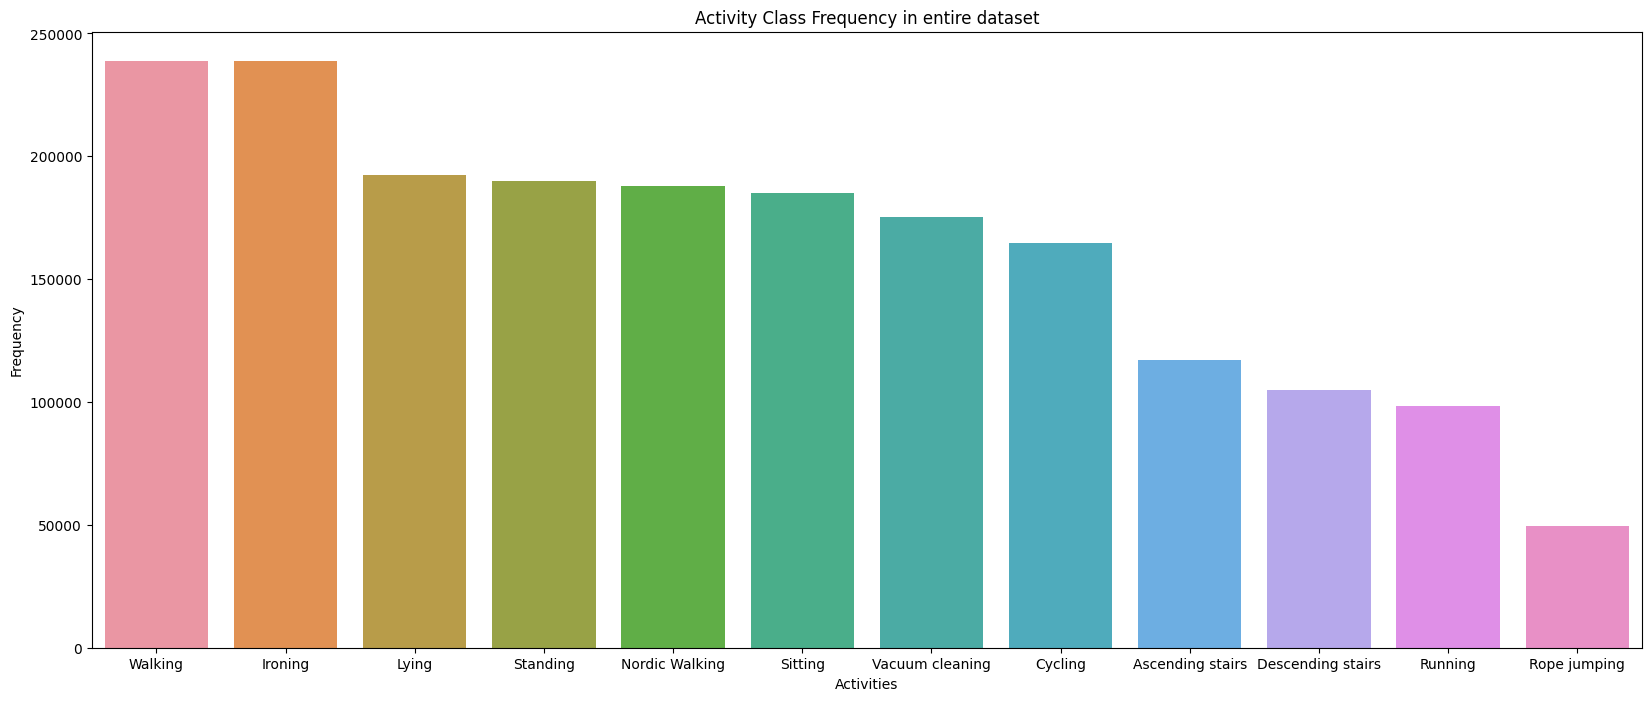

In [ ]:
# frequency of each activity in entire dataset
plt.figure(figsize=(20,8))
plt.title("Activity Class Frequency in entire dataset")
sns.countplot(data = df[df['activityID'] != 0], x = 'activity', order=df[df['activityID'] != 0]['activity'].value_counts().index)
plt.xlabel("Activities")
plt.ylabel("Frequency")


Text(0, 0.5, 'Frequency')

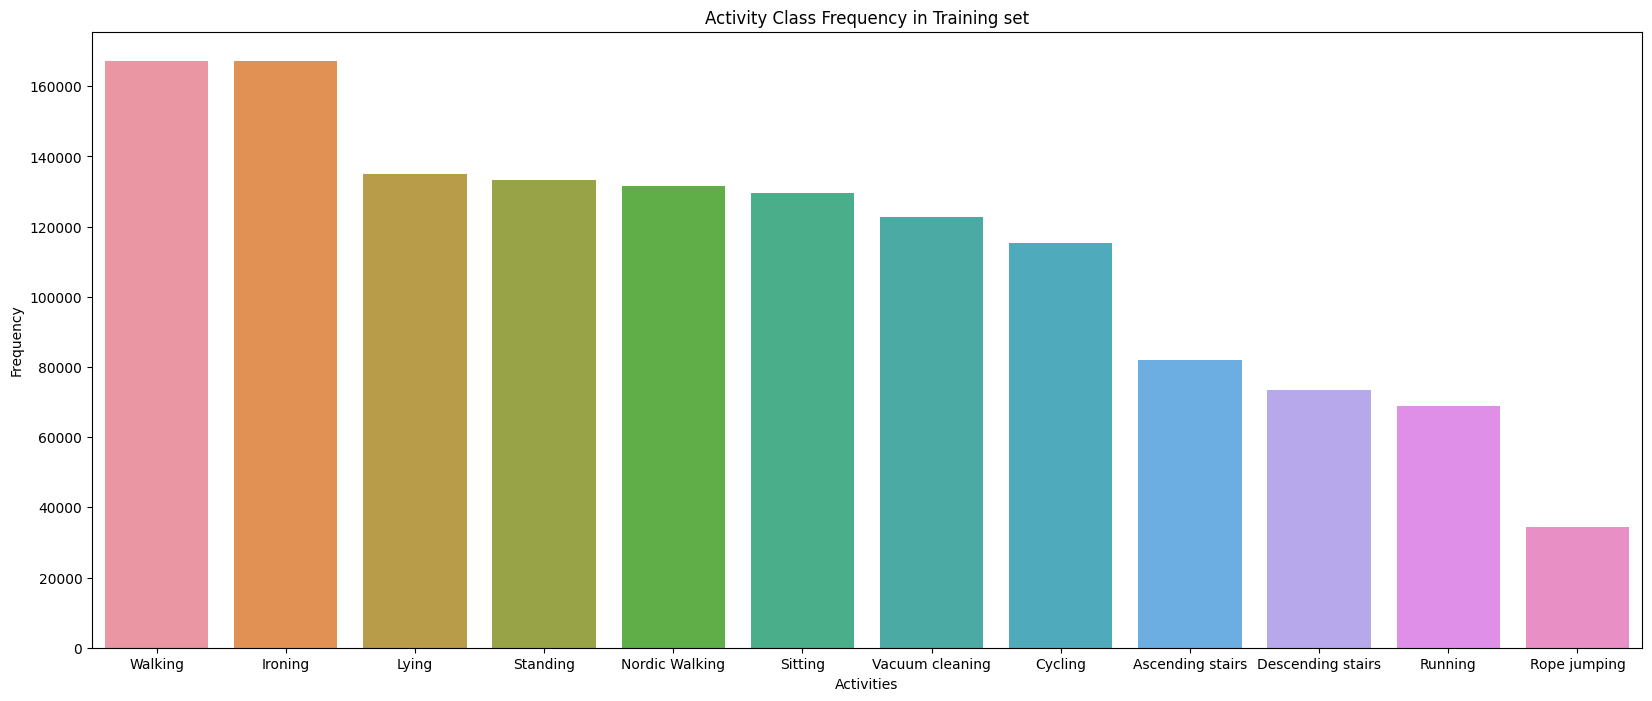

In [ ]:
# frequency of each activity in training set
plt.figure(figsize=(20,8))
plt.title("Activity Class Frequency in Training set")
sns.countplot(data = X_train, x = 'activity', order=X_train['activity'].value_counts().index )
plt.xlabel("Activities")
plt.ylabel("Frequency")

## 3.2 What is the heartrate plot for each subject with time?

The heart rate is the number of times the heart beats per minute. It is typically measured in beats per minute (bpm). The normal resting heart rate for an adult is between 60 and 100 bpm, although this can vary depending on factors such as age, physical activity level, and overall health.

We visualize a plot containing nine sub plots pertaining to each subject. These plots show the heart rate at timestamp, such as during a workout or while sleeping, standing. The x-axis represents timestamp with a resolution of 0.01, and the y-axis represents the heart rate in beats per minute (bpm). This plot can be used to track changes in the heart rate over time and to identify patterns or trends.


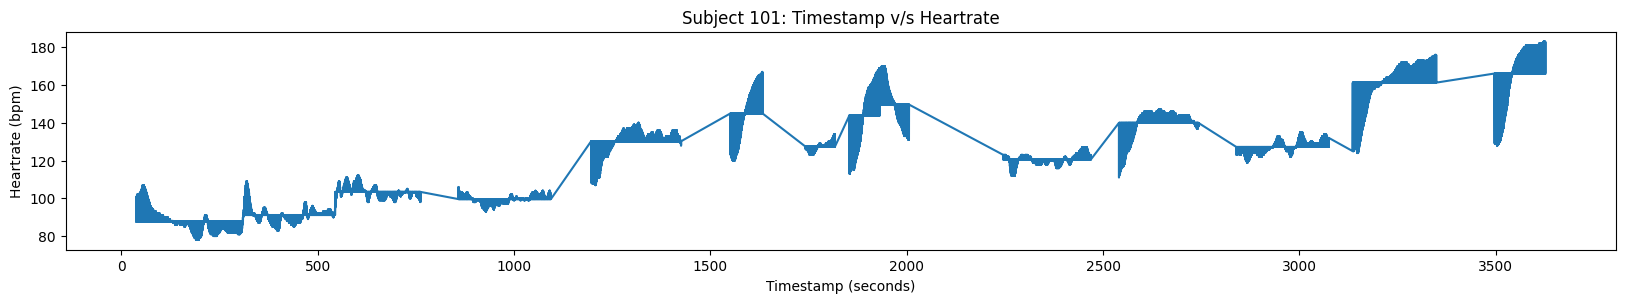

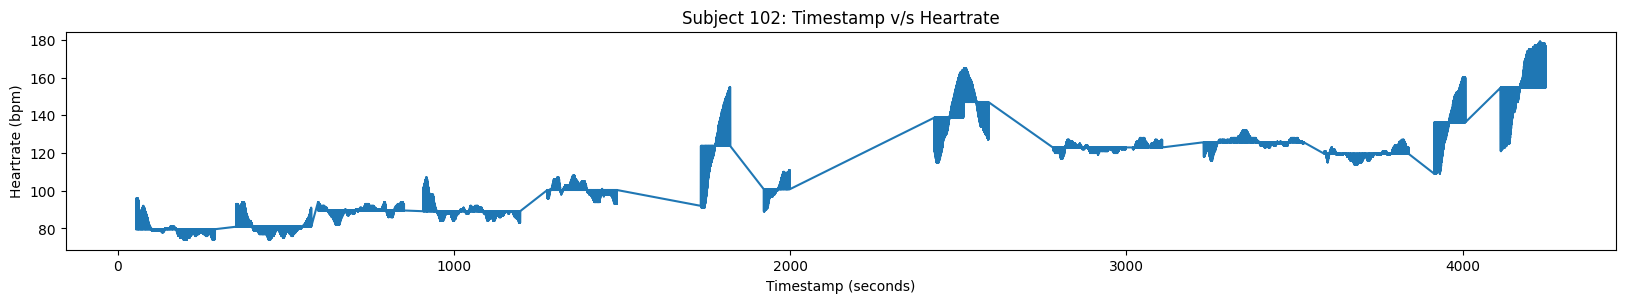

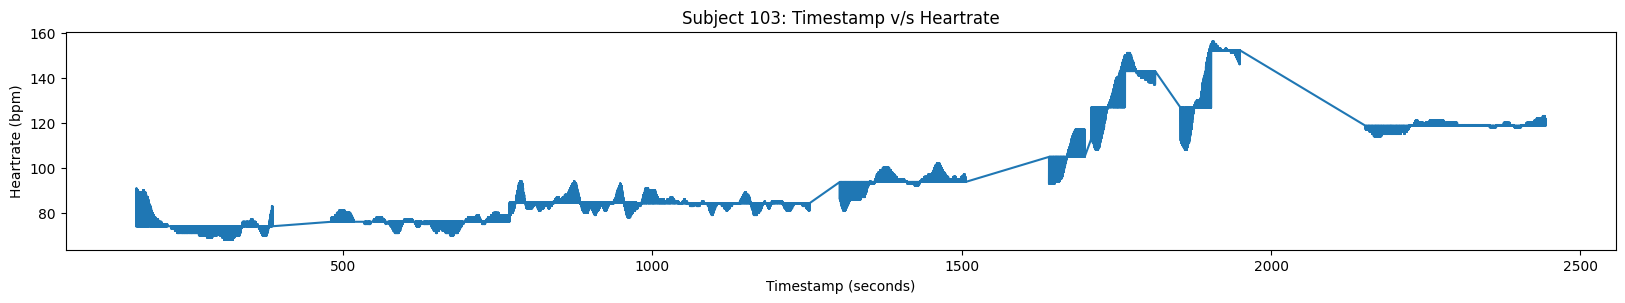

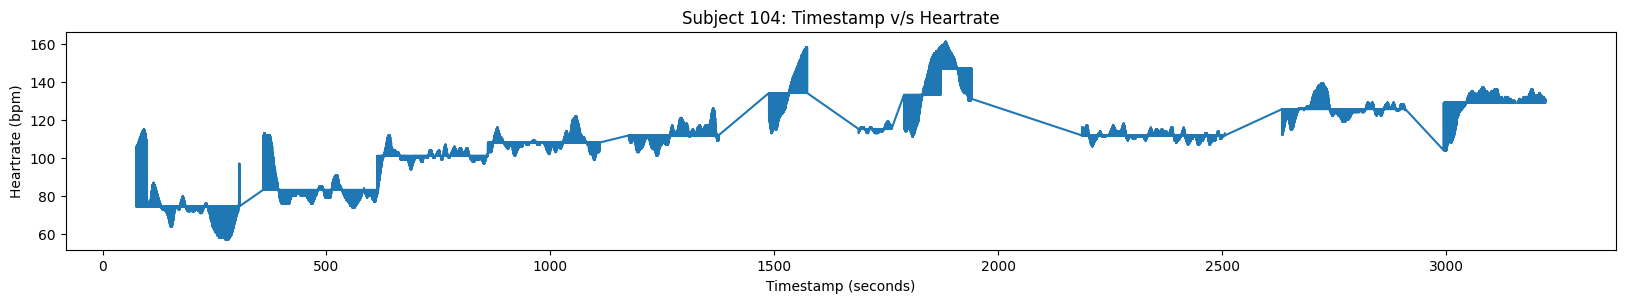

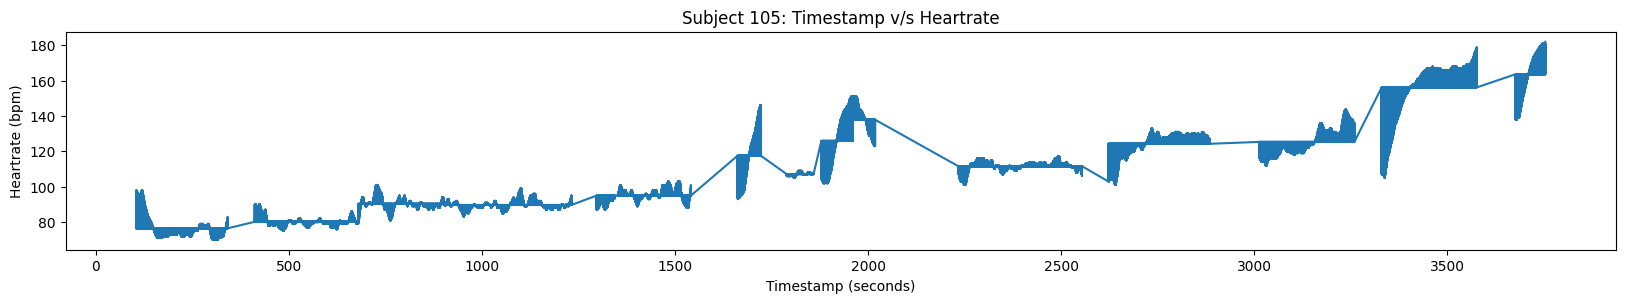

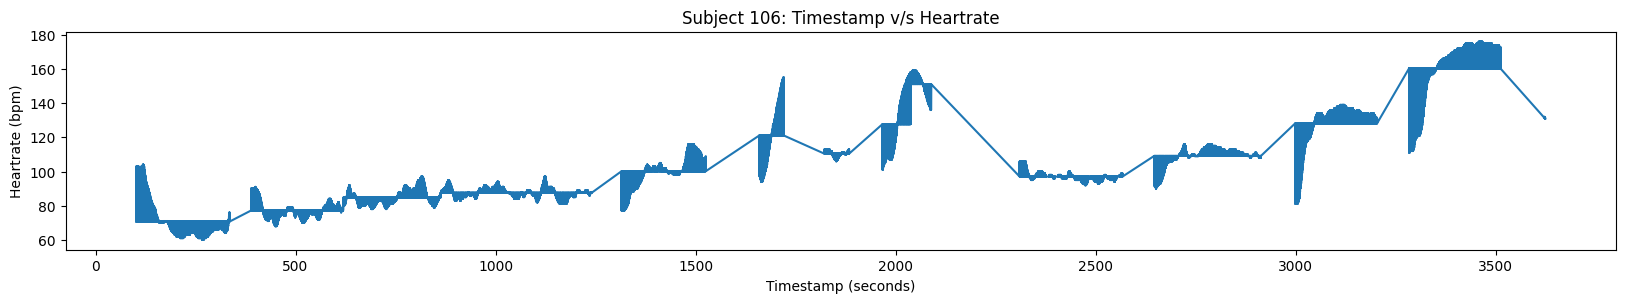

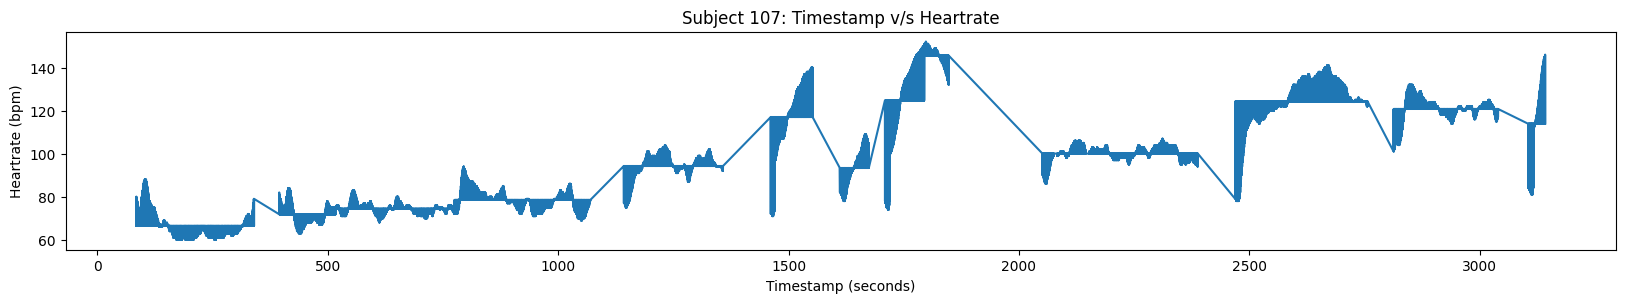

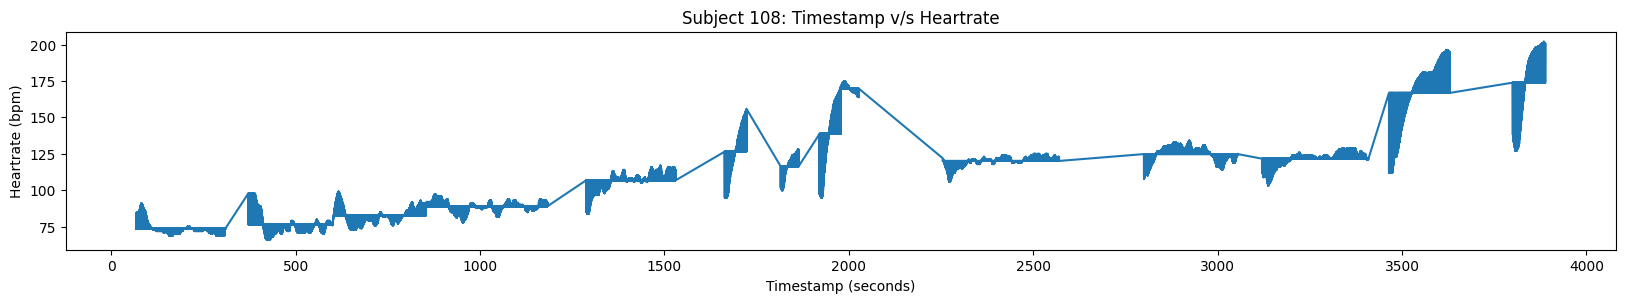

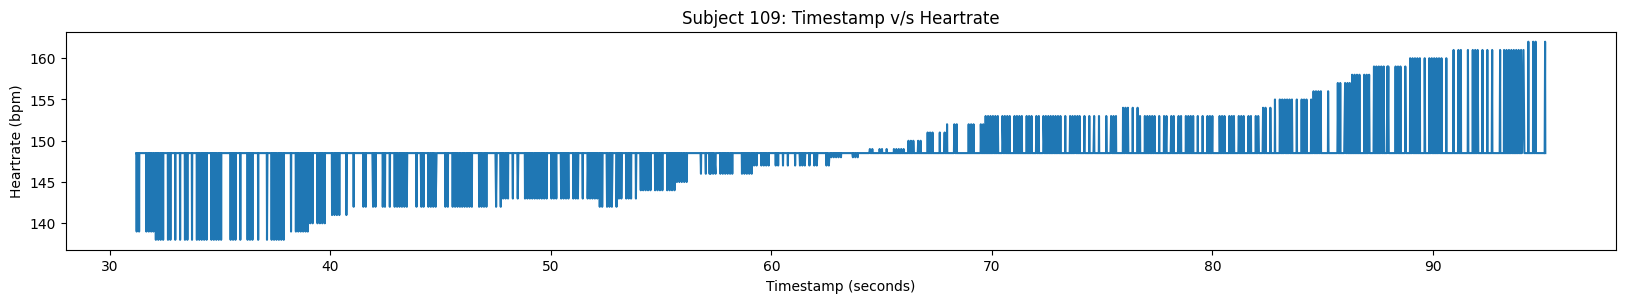

In [ ]:
for i in range(1,10):
  heartrate = X_train[X_train['subject no.'] == i]['heartrate']
  timestamp = X_train[X_train['subject no.'] == i]['timestamp']
  plt.figure(figsize = (20,30))
  plt.subplot(9, 1, i)
  plt.title("Subject 10"+ str(i)+": Timestamp v/s Heartrate")
  plt.plot(timestamp, heartrate)
  plt.xlabel("Timestamp (seconds)")
  plt.ylabel("Heartrate (bpm)")

## 3.3 What is the average heartrate for each activity?

This plot shows the average heart rate at different types of physical activity. The x-axis represents the types of the activity, and the y-axis represents the average heart rate in bpm. This plot can be used to determine the relationship between average heart rate and types of physical activity and to identify the average heart rate range that is optimal for different types of physical activity. We see Running, Ascending stairs, and Rope jumping have the highest average heartrate while standing, sitting and lying are amongst the activities with lowest heartrate.

<BarContainer object of 12 artists>

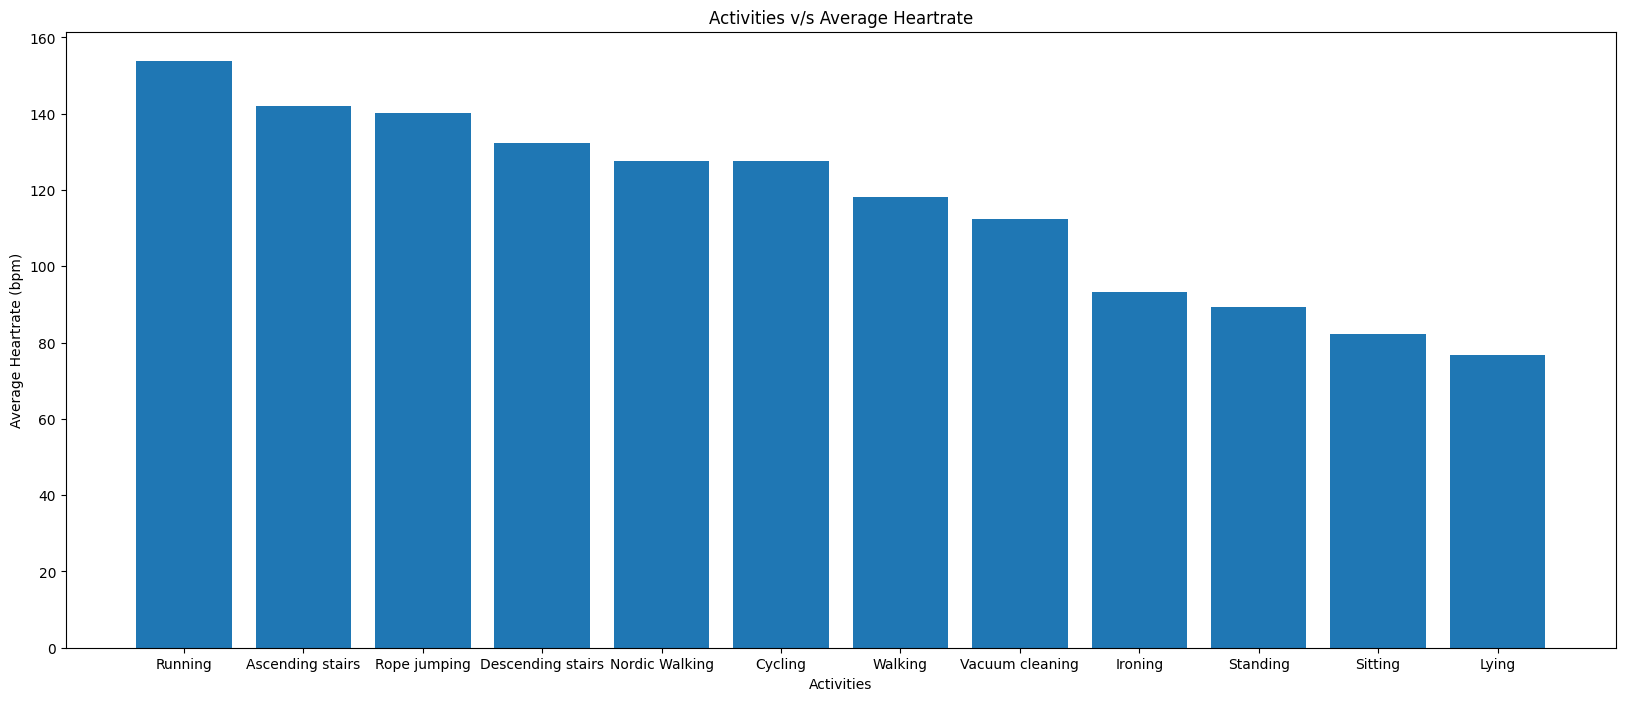

In [ ]:
import matplotlib.pyplot as plt
groupedDF = xTrainDuration.groupby(['activity']).mean()['heartrate']
groupedDF = groupedDF.sort_values(ascending = False)
plt.figure(figsize=(20,8))
plt.title("Activities v/s Average Heartrate")
plt.xlabel("Activities")
plt.ylabel("Average Heartrate (bpm)")
plt.bar(groupedDF.index, groupedDF.values)


## 3.4 What is the average duration of each activity?

The average duration of physical activity refers to the amount of time that all subjects spend engaged in a particular type of physical activity.

This plot shows the average duration of different types of physical activities. The x-axis represents the type of activity, and the y-axis represents the average duration in seconds. This plot can be used to compare the average duration of different types of activities and to identify which activities participants spend the most time on, on average.


<BarContainer object of 12 artists>

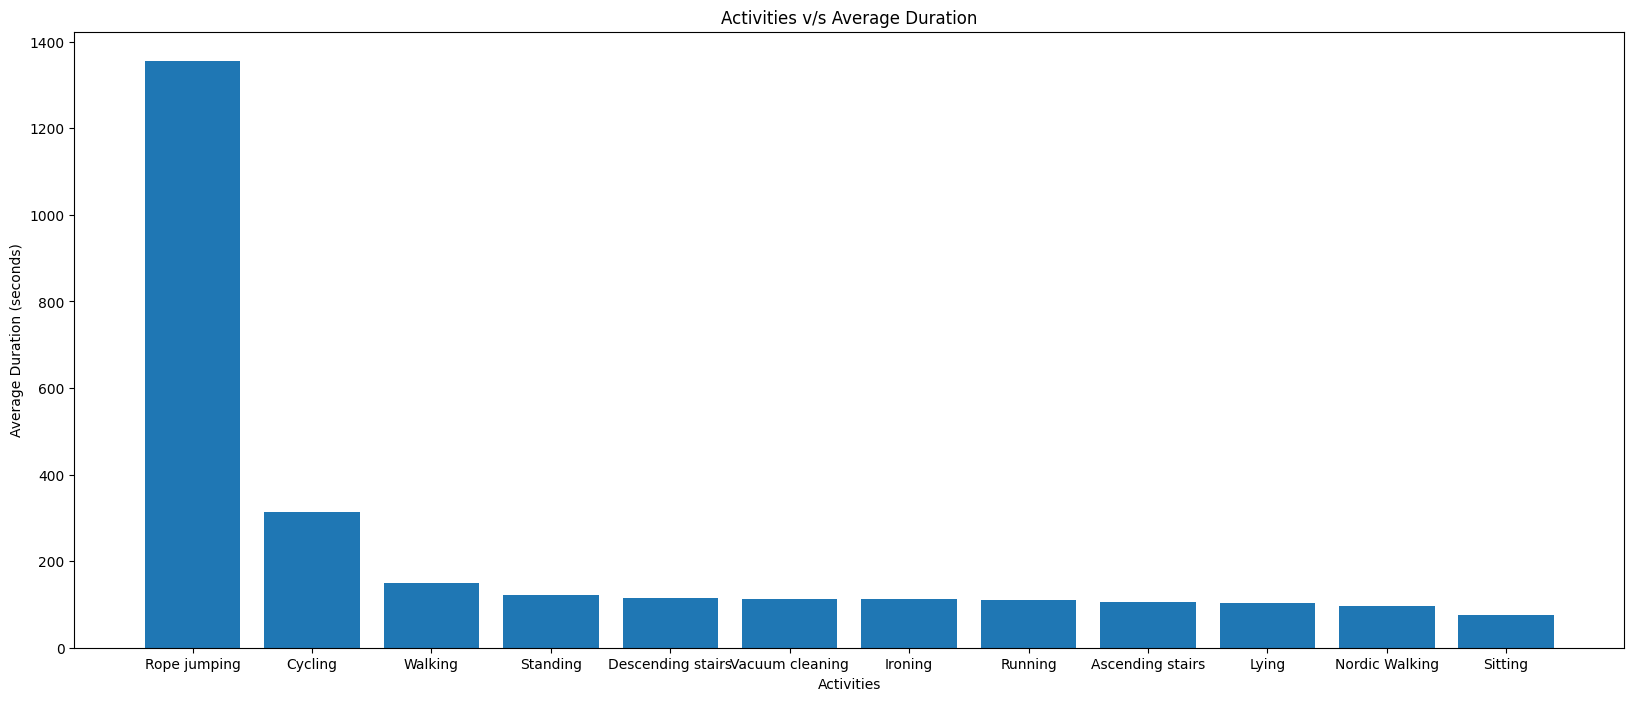

In [ ]:
groupedDF = xTrainDuration.groupby(['activity']).mean()['duration']
groupedDF = groupedDF.sort_values(ascending = False)
plt.figure(figsize=(20,8))
plt.title("Activities v/s Average Duration")
plt.xlabel("Activities")
plt.ylabel("Average Duration (seconds)")
plt.bar(groupedDF.index, groupedDF.values)

## 3.5 What is the total duration of each activity?

The total duration of a physical activity refers to the amount of time that all  individuals spend engaged in a particular type of physical activity over a given period of time.

This plot shows the total duration of different types of physical activities. The x-axis represents the type of activity, and the y-axis represents the total duration in seconds. This plot can be used to compare the total duration of different types of activities and to identify which activities people spend the most time on.


<BarContainer object of 12 artists>

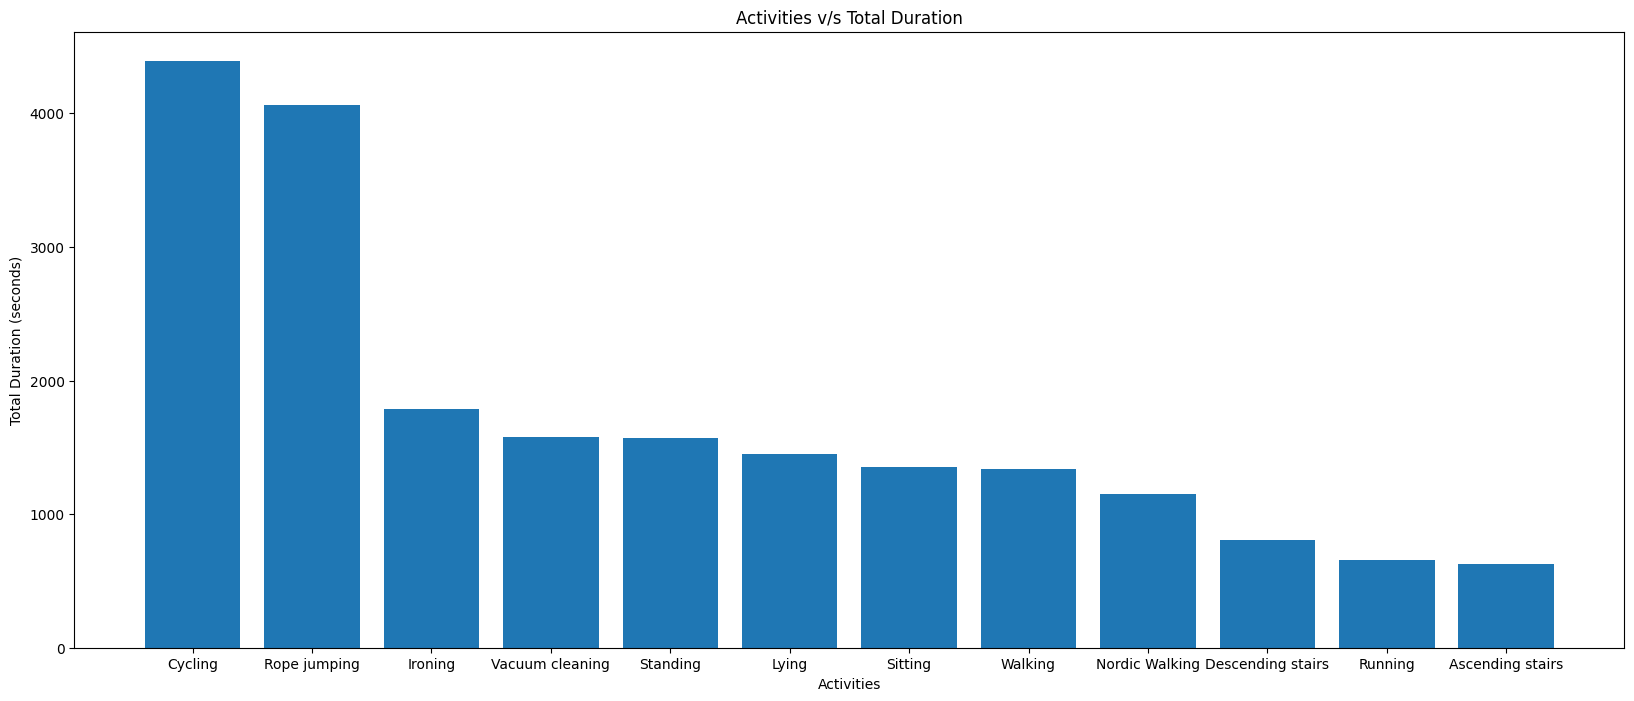

In [ ]:
groupedDF = xTrainDuration.groupby(['activity']).sum()['duration']
groupedDF = groupedDF.sort_values(ascending = False)
plt.figure(figsize=(20,8))
plt.title("Activities v/s Total Duration")
plt.xlabel("Activities")
plt.ylabel("Total Duration (seconds)")
plt.bar(groupedDF.index, groupedDF.values)

## 3.6 What is the average temperature for each activity?

This plot shows the types of physical activities that are performed at different average temperatures from ankle, chest, and hand sensors. The x-axis represents the type of activity, and the y-axis represents the average temperature. This plot can be used to identify which types of activities are most commonly performed at different temperatures and to determine the temperature that is optimal for different types of activity.

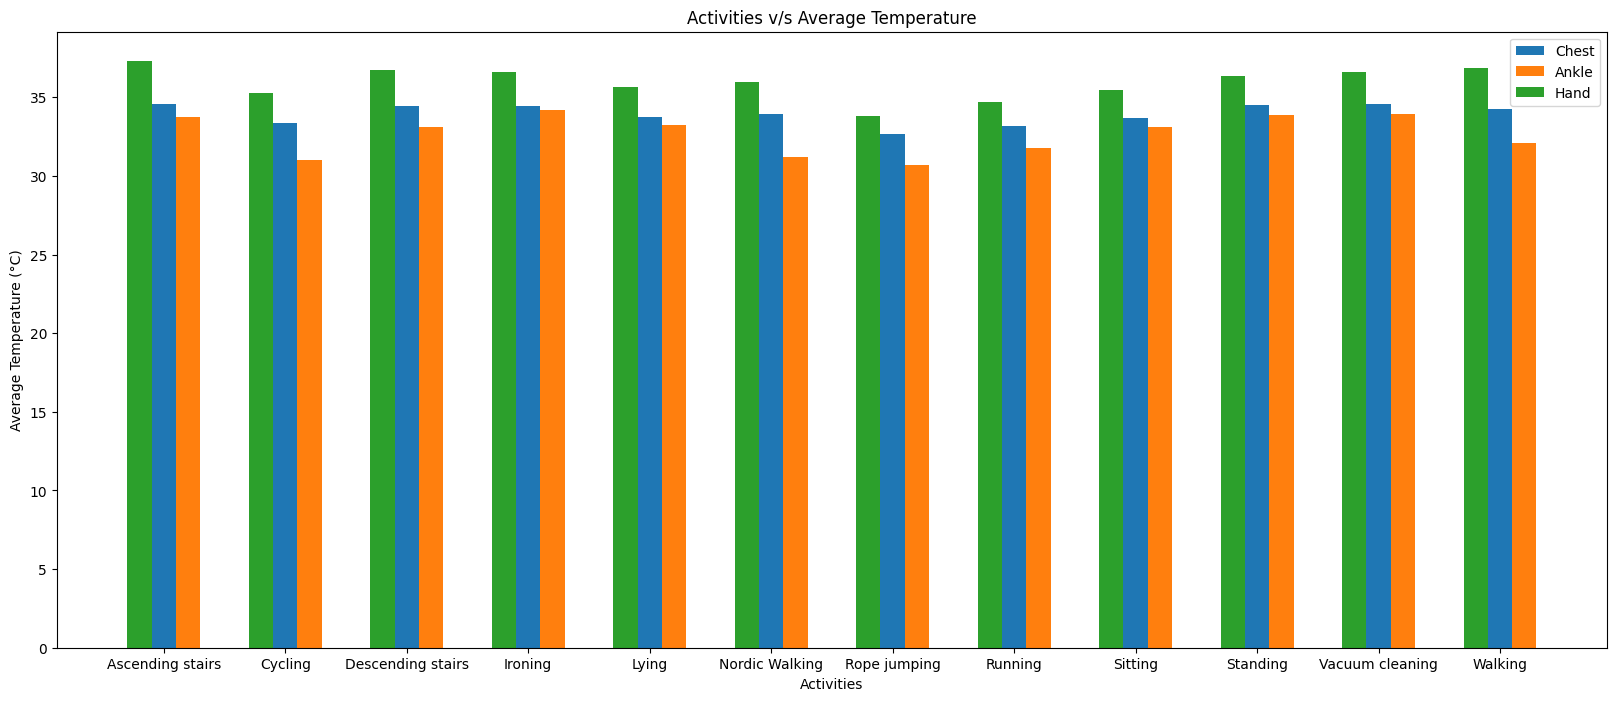

In [ ]:
groupedTemperatureDF = xTrainDuration.groupby(['activity']).mean()[['IMUhand_temperature', 'IMUchest_temperature', 'IMUankle_temperature']]
activities = groupedTemperatureDF.index
x = np.arange(len(groupedTemperatureDF))
ankle = groupedTemperatureDF['IMUankle_temperature'].values
chest = groupedTemperatureDF['IMUchest_temperature'].values
hand = groupedTemperatureDF['IMUhand_temperature'].values
width = 0.20

plt.figure(figsize=(20,8))
plt.title("Activities v/s Average Temperature")

plt.bar(x, ankle, width, label = "Ankle")
plt.bar(x+0.2, hand, width, label = "Hand")
plt.bar(x-0.2, chest, width, label = "Chest")
plt.xticks(x, activities)
plt.xlabel("Activities")
plt.ylabel("Average Temperature (°C)")
plt.legend(["Chest","Ankle", "Hand"])
plt.show()



## 3.7 What is the average magnitude of acceleration for each activity?

Physical activity can be plotted against the average magnitude of acceleration to see the relationship between the two variables. The magnitude of acceleration refers to the size or strength of an acceleration and is derived using the formula:|a| =  √(x<sup>2</sup>+y<sup>2</sup>+z<sup>2</sup> ).

This plot shows the types of physical activities that are performed at different average magnitudes of acceleration. The x-axis represents the type of activity, and the y-axis represents the average magnitude of acceleration for all sensors (ankle, chest, and hand). This plot can be used to identify which types of activities are associated with different average magnitudes of acceleration and to determine the of acceleration magnitudes that is optimal for different types of activity. The magnitude of acceleration is high for running and rope jumping. It is low for lying and sitting.


Text(0, 0.5, 'Average of Magnitude of Acceleration (ms⁻²)')

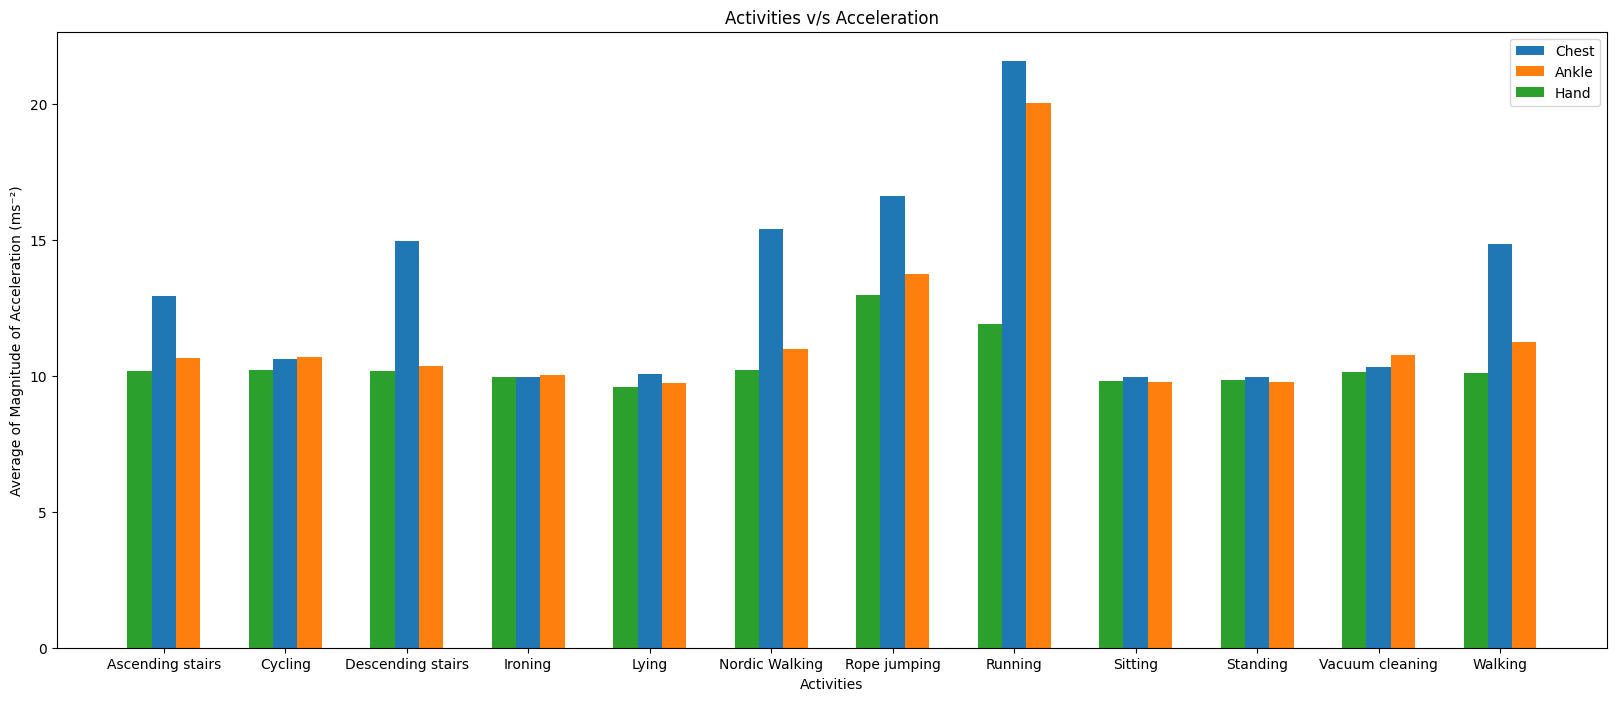

In [ ]:

x_AccHand = X_train['IMUhand_acc16X']
y_AccHand = X_train['IMUhand_acc16Y']
z_AccHand = X_train['IMUhand_acc16Z']
X_train['IMUhand_acc16'] = np.sqrt(x_AccHand**2 + y_AccHand**2 + z_AccHand**2) 

x_AccChest = X_train['IMUchest_acc16X']
y_AccChest = X_train['IMUchest_acc16Y']
z_AccChest = X_train['IMUchest_acc16Z']
X_train['IMUchest_acc16'] = np.sqrt(x_AccChest**2 + y_AccChest**2 + z_AccChest**2) 

x_AccCAnkle = X_train['IMUankle_acc16X']
y_AccAnkle = X_train['IMUankle_acc16Y']
z_AccAnkle = X_train['IMUankle_acc16Z']
X_train['IMUankle_acc16'] = np.sqrt(x_AccCAnkle**2 + y_AccAnkle**2 + z_AccAnkle**2) 

groupedAccDF = X_train.groupby(['activity']).mean()[['IMUhand_acc16', 'IMUchest_acc16', 'IMUankle_acc16']]
activities = groupedAccDF.index
x = np.arange(len(groupedAccDF))
ankle = groupedAccDF['IMUankle_acc16'].values
chest = groupedAccDF['IMUchest_acc16'].values
hand = groupedAccDF['IMUhand_acc16'].values
plt.figure(figsize=(20,8))
plt.title("Activities v/s Acceleration")
plt.bar(x, ankle, width, label = "Ankle")
plt.bar(x+0.2, hand, width, label = "Hand")
plt.bar(x-0.2, chest, width, label = "Chest")
plt.xticks(x, activities)
plt.xlabel("Activities")
plt.legend(["Chest","Ankle", "Hand"])
plt.ylabel("Average of Magnitude of Acceleration (ms⁻²)")

## 3.8 What is the magnitude of acceleration per subject with time?

 The plots show the magnitude of acceleration for different people at different times. The x-axis represents the timestamp with a resolution of 0.01 second, and the y-axis represents the magnitude of acceleration. These plots can be used to see how the magnitude of acceleration changes over time for different people and to identify any patterns or trends in the data.

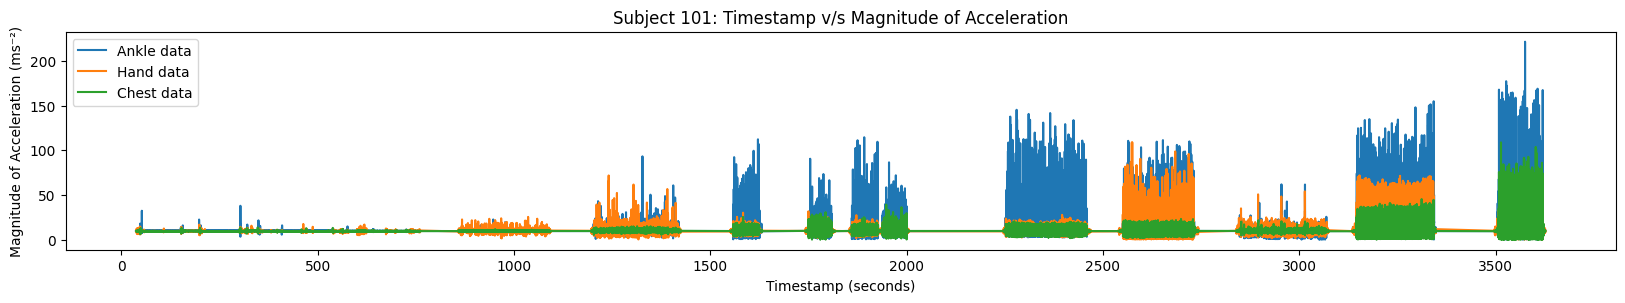

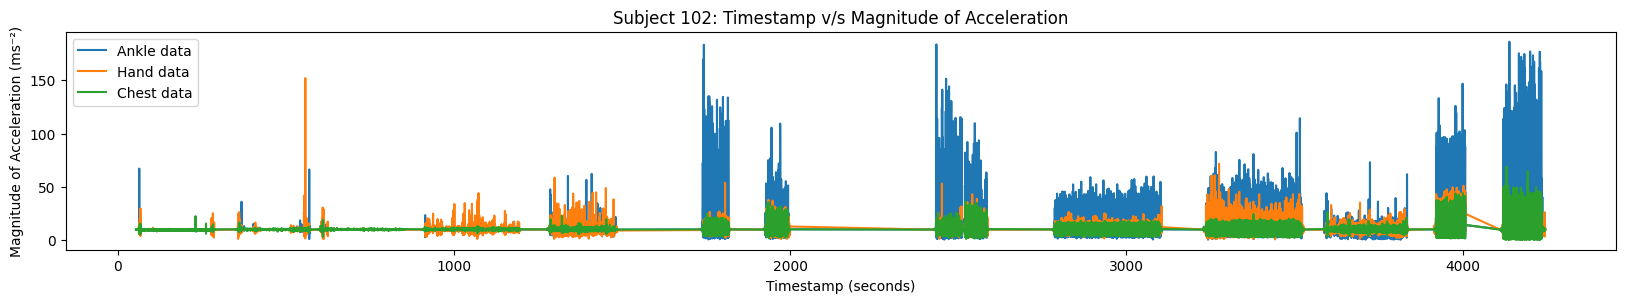

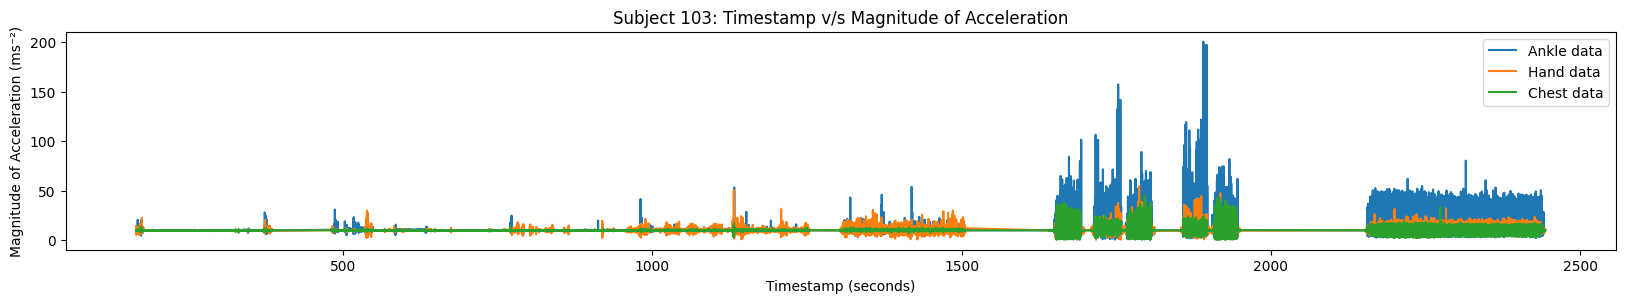

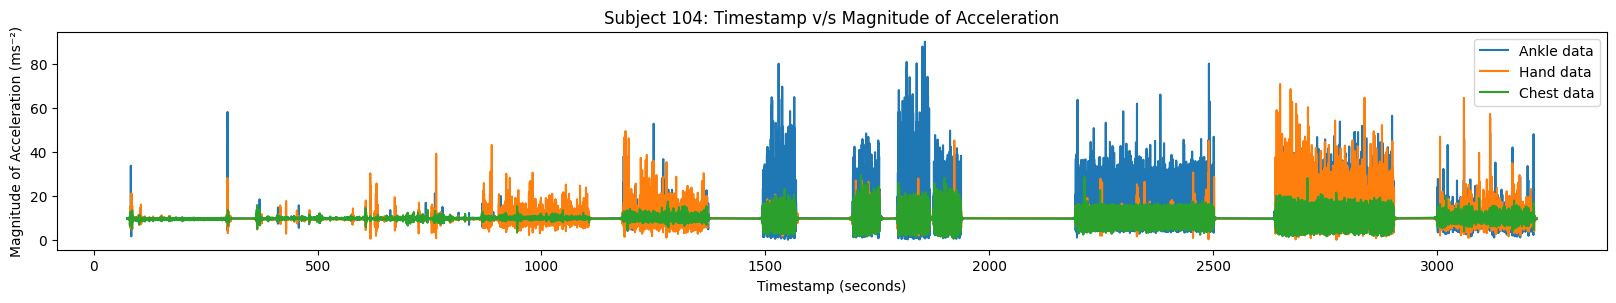

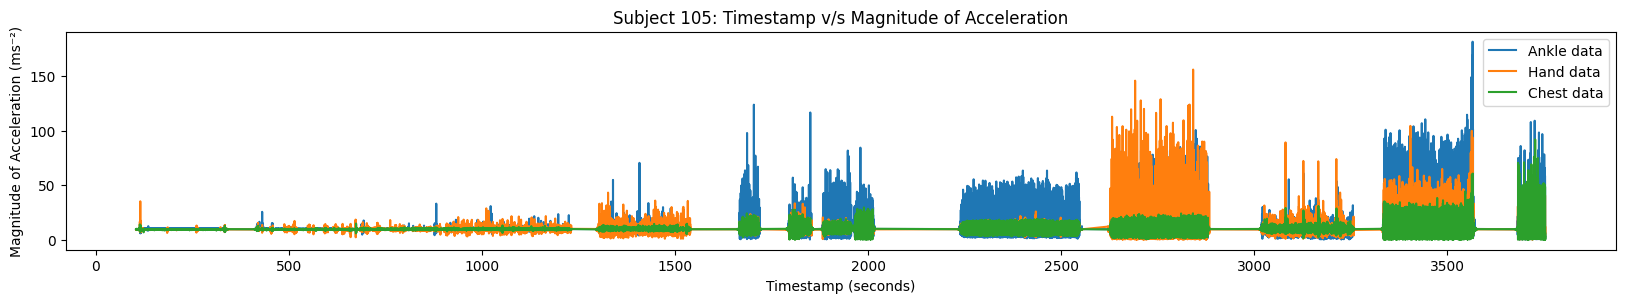

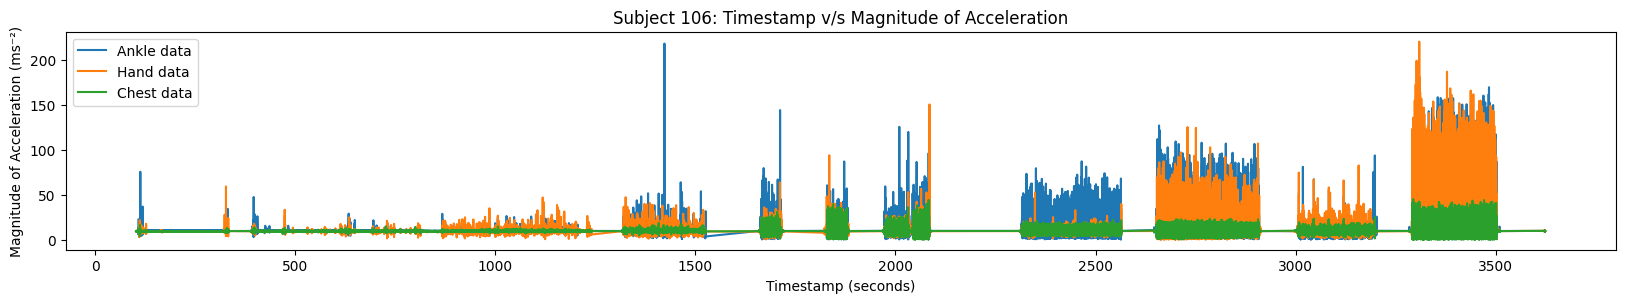

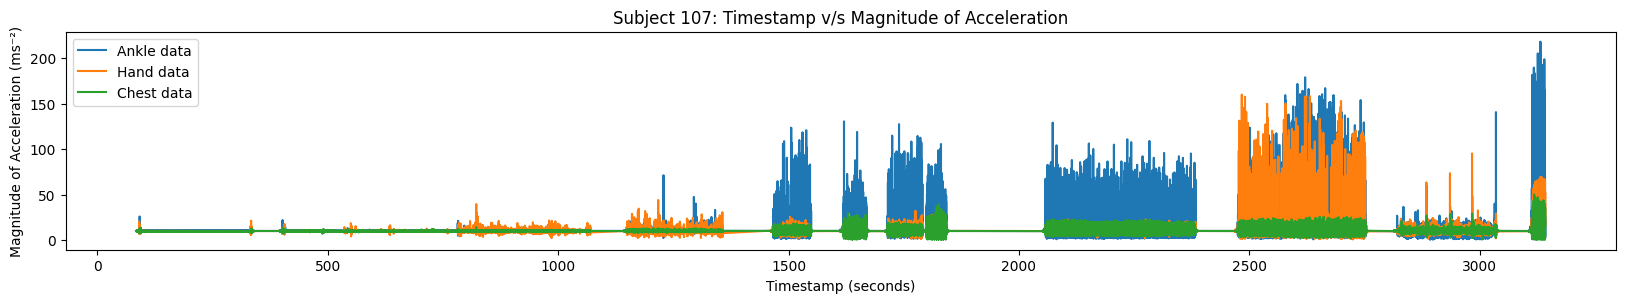

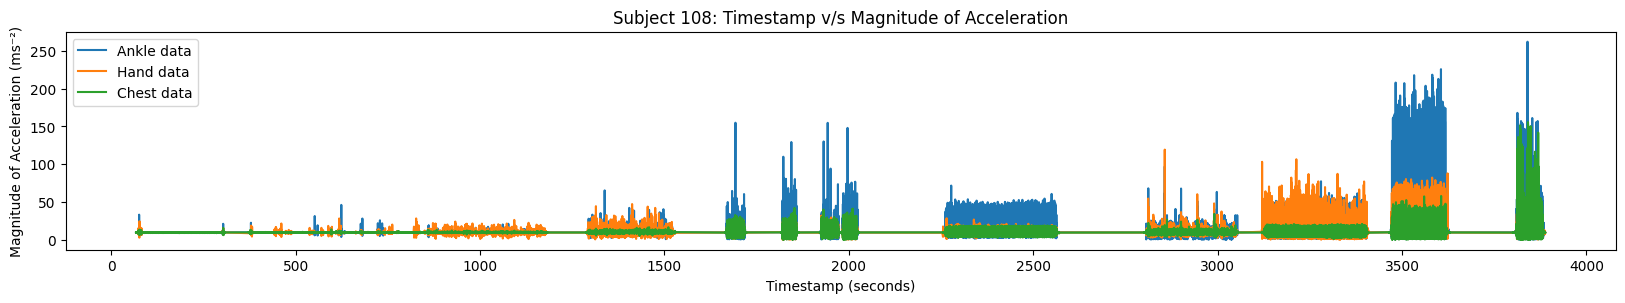

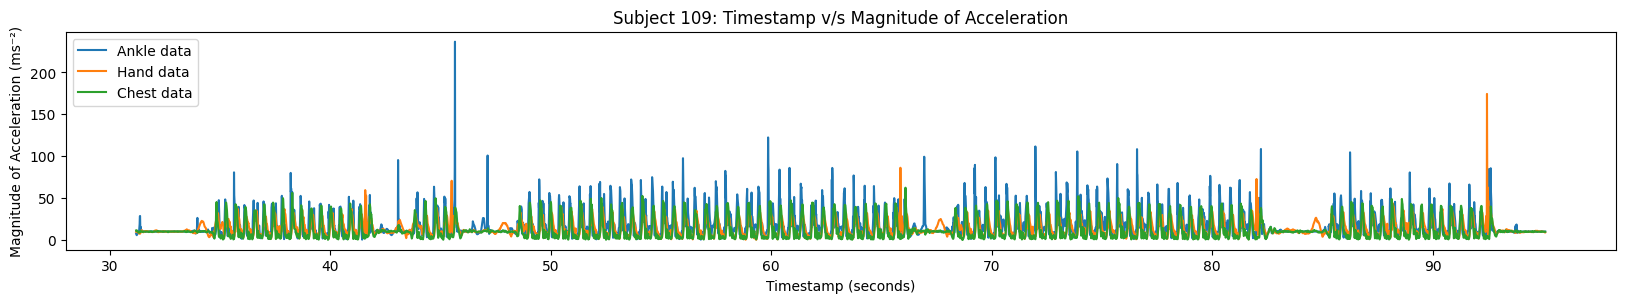

In [ ]:
for i in range(1,10):
  accAnkle = X_train[X_train['subject no.'] == i]['IMUankle_acc16']
  accHand = X_train[X_train['subject no.'] == i]['IMUhand_acc16']
  accChest = X_train[X_train['subject no.'] == i]['IMUchest_acc16']
  timestamp = X_train[X_train['subject no.'] == i]['timestamp']
  plt.figure(figsize = (20,30))
  plt.subplot(9, 1, i)
  plt.title("Subject 10"+ str(i)+": Timestamp v/s Magnitude of Acceleration")
  plt.plot(timestamp, accAnkle, label = "Ankle data")
  plt.plot(timestamp, accHand, label = "Hand data")
  plt.plot(timestamp, accChest, label = "Chest data")
  plt.legend()
  plt.xlabel("Timestamp (seconds)")
  plt.ylabel("Magnitude of Acceleration (ms⁻²)")

## 3.9 What is the average magnitude of gyroscope data for each activity?

The magnitude of gyroscope data refers to the size or strength of the angular velocity measured by a gyroscope. It is typically measured in radians per second (rad/s). This plot shows the types of physical activities that are performed at different average magnitudes of gyroscope data. The x-axis represents the type of activity, and the y-axis represents the average magnitude of gyroscope data. This plot can be used to identify which types of activities are associated with different average magnitudes of gyroscope data and to determine the range of gyroscope data magnitudes that is optimal for different types of activity. The magnitude of gyroscope data is high for running and rope jumping. It is low for lying and sitting, as seen below.

Text(0, 0.5, 'Average of Magnitude of Gyroscope data (rad/s)')

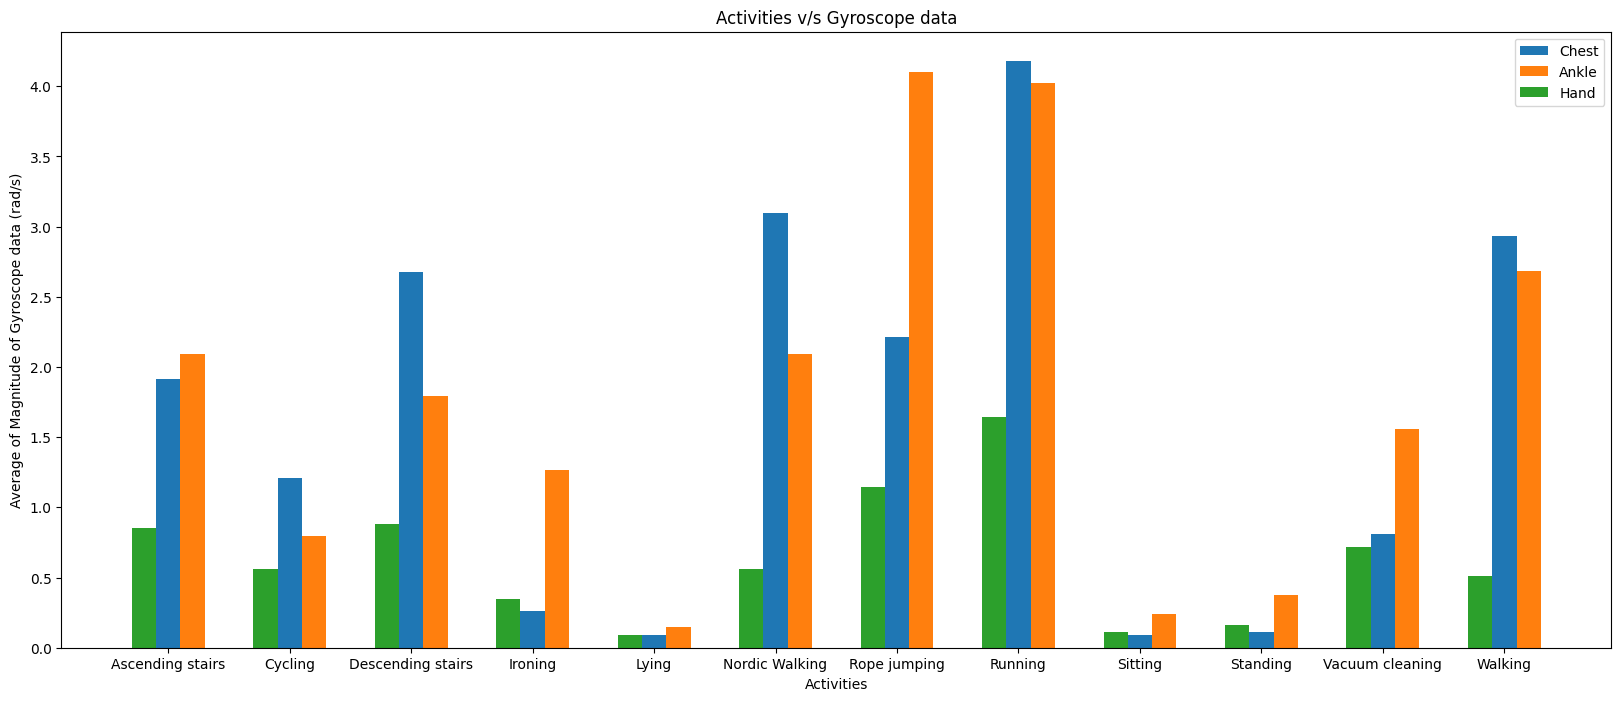

In [ ]:
x_GyroHand = X_train['IMUhand_gyroX']
y_GyroHand = X_train['IMUhand_gyroY']
z_GyroHand = X_train['IMUhand_gyroZ']
X_train['IMUhand_gyro'] = np.sqrt(x_GyroHand**2 + y_GyroHand**2 + z_GyroHand**2) 

x_GyroChest = X_train['IMUchest_gyroX']
y_GyroChest = X_train['IMUchest_gyroY']
z_GyroChest = X_train['IMUchest_gyroZ']
X_train['IMUchest_gyro'] = np.sqrt(x_GyroChest**2 + y_GyroChest**2 + z_GyroChest**2) 

x_GyroCAnkle = X_train['IMUankle_gyroX']
y_GyroAnkle = X_train['IMUankle_gyroY']
z_GyroAnkle = X_train['IMUankle_gyroZ']
X_train['IMUankle_gyro'] = np.sqrt(x_GyroCAnkle**2 + y_GyroAnkle**2 + z_GyroAnkle**2) 

groupedGyroDF = X_train.groupby(['activity']).mean()[['IMUhand_gyro', 'IMUchest_gyro', 'IMUankle_gyro']]
activities = groupedGyroDF.index
x = np.arange(len(groupedGyroDF))
ankle = groupedGyroDF['IMUankle_gyro'].values
chest = groupedGyroDF['IMUchest_gyro'].values
hand = groupedGyroDF['IMUhand_gyro'].values
plt.figure(figsize=(20,8))
plt.title("Activities v/s Gyroscope data")

plt.bar(x, ankle, width, label = "Ankle")
plt.bar(x+0.2, hand, width, label = "Hand")
plt.bar(x-0.2, chest, width, label = "Chest")
plt.xticks(x, activities)
plt.xlabel("Activities")
plt.legend(["Chest","Ankle", "Hand"])
plt.ylabel("Average of Magnitude of Gyroscope data (rad/s)")

## 3.10 What is the magnitude of gyroscope data subject with time?

The plots show the magnitude of gyroscope data for a single subject at different timestamps of resolution 0.01 second. The x-axis represents the timestamp, and the y-axis represents the magnitude of gyroscope data. This plot can be used to see how the magnitude of gyroscope data changes over time for a single subject and to identify any patterns or trends in the data.

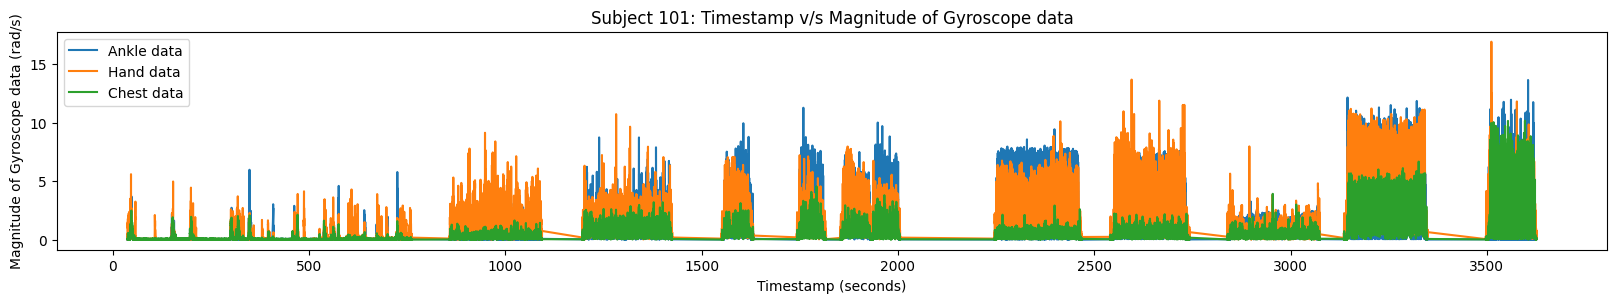

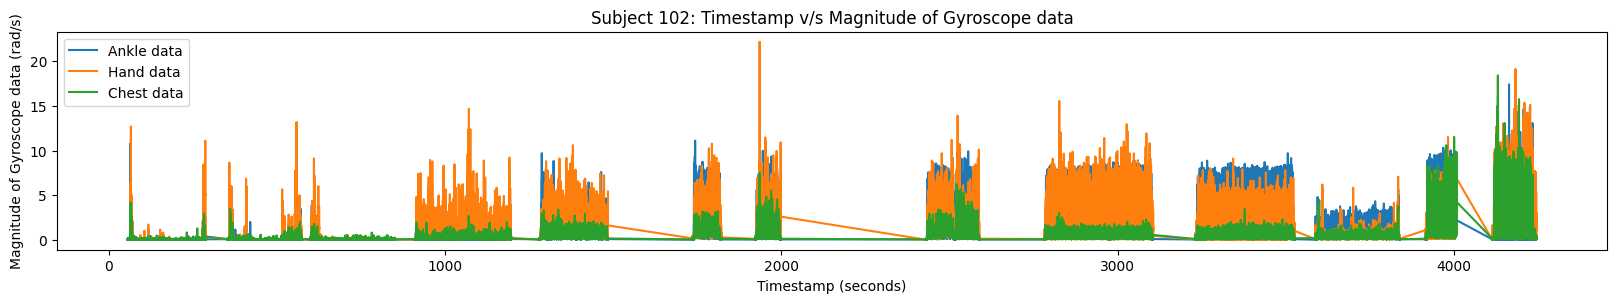

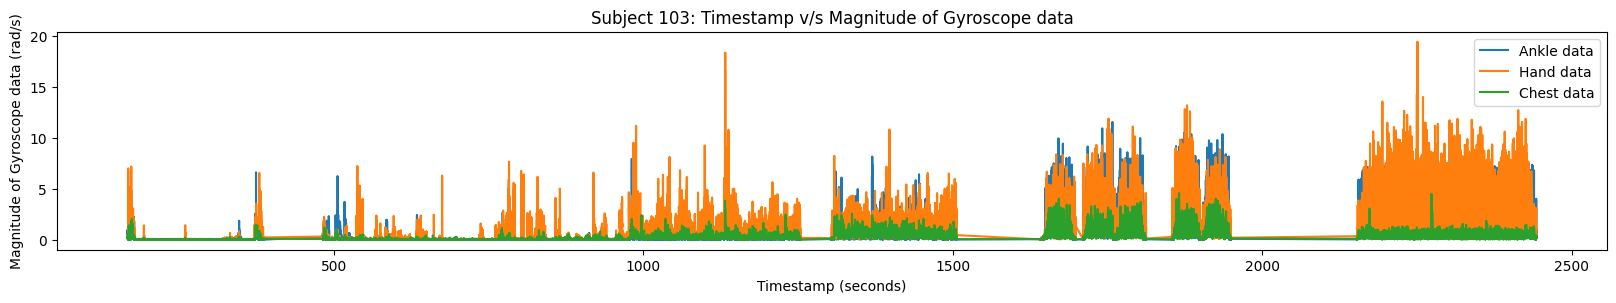

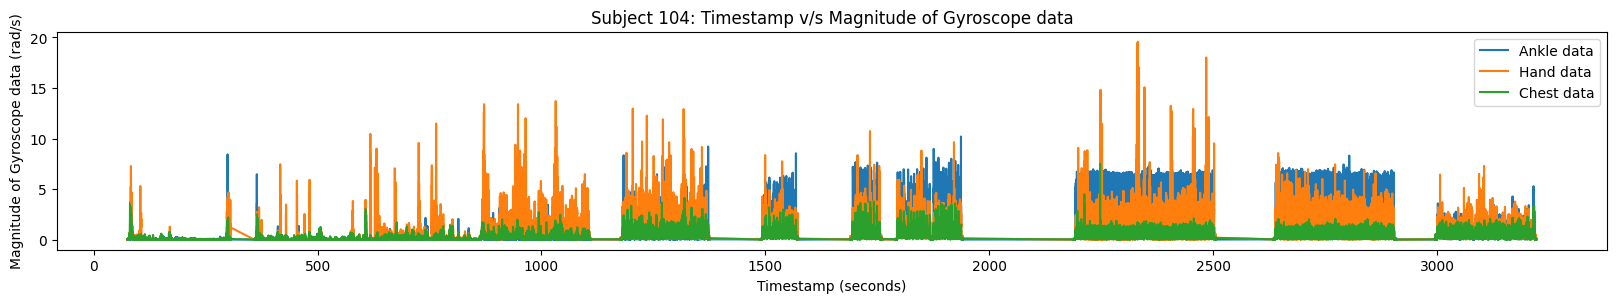

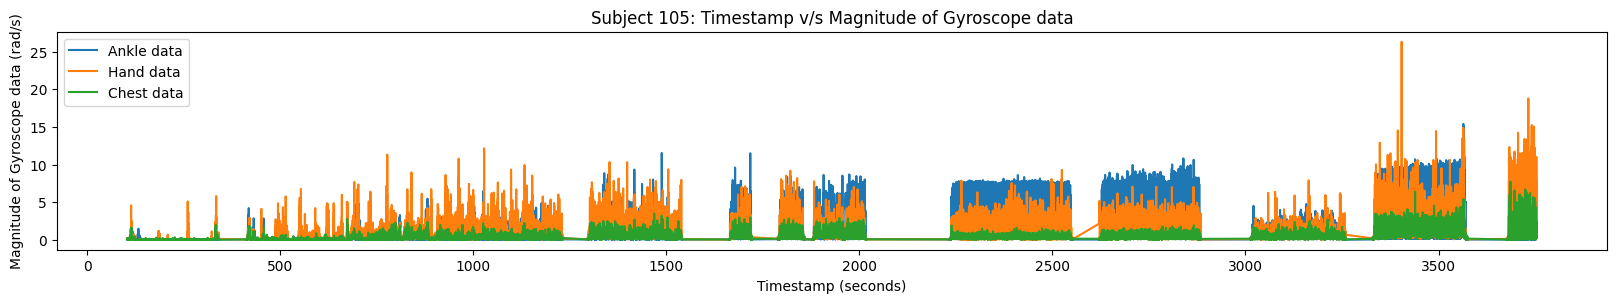

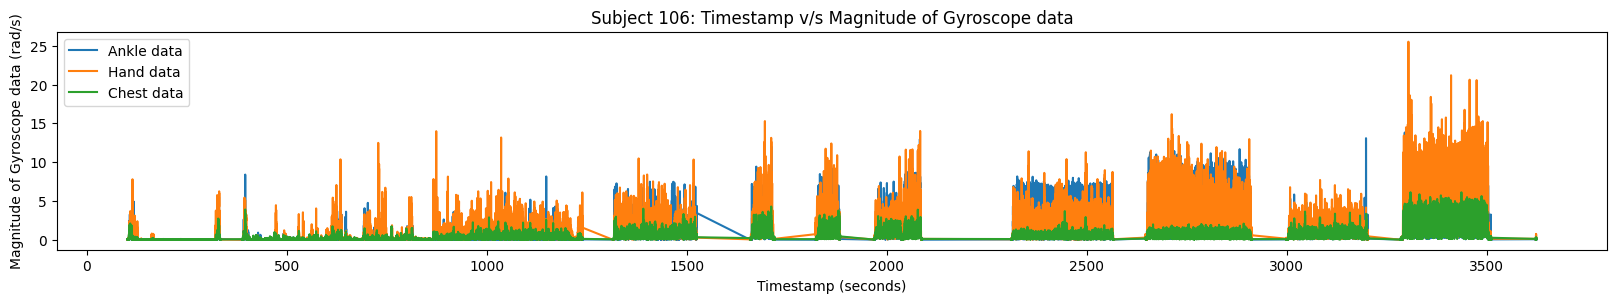

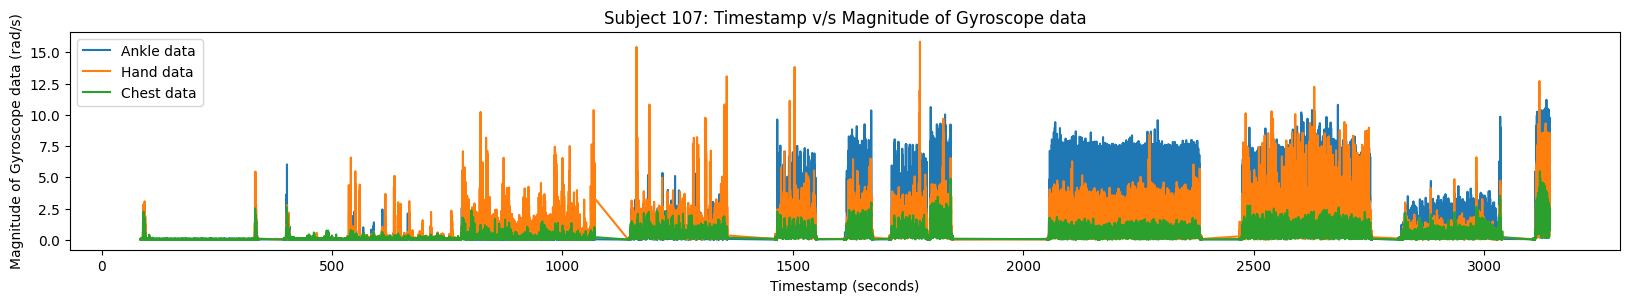

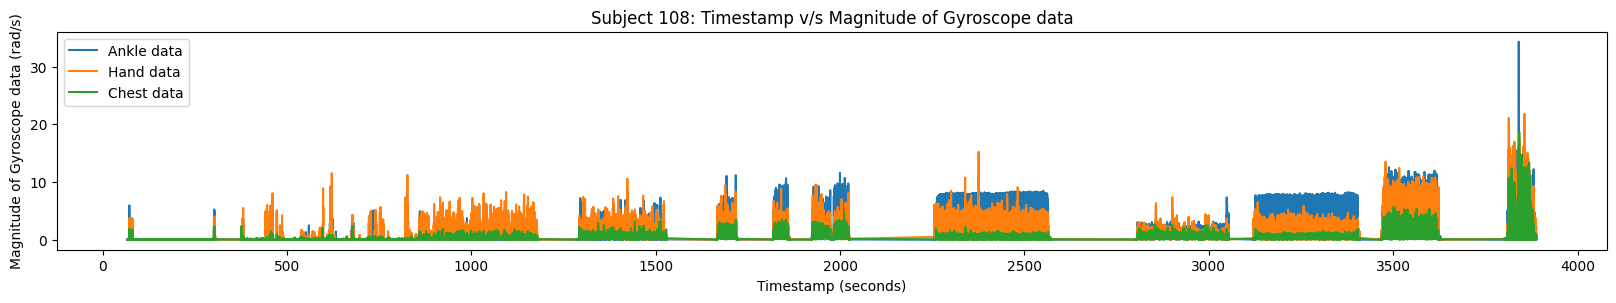

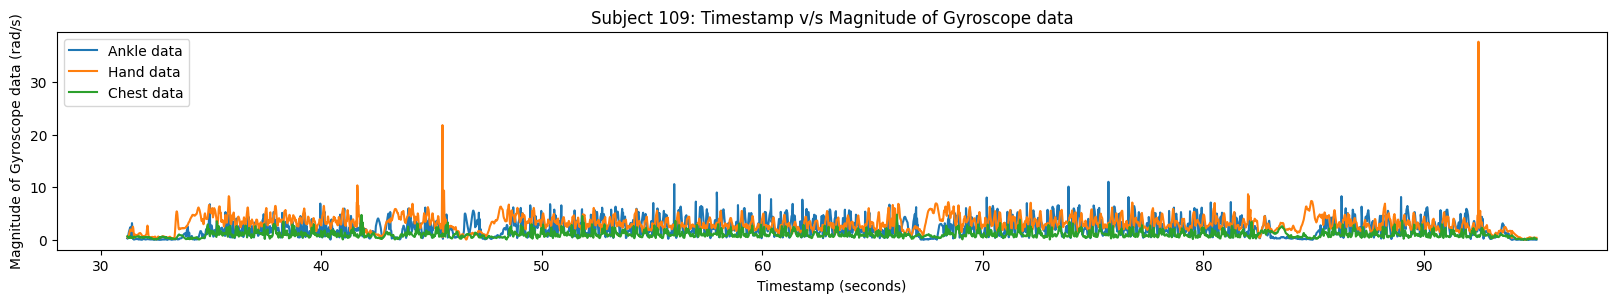

In [ ]:
for i in range(1,10):
  gyroAnkle = X_train[X_train['subject no.'] == i]['IMUankle_gyro']
  gyroHand = X_train[X_train['subject no.'] == i]['IMUhand_gyro']
  gyroChest = X_train[X_train['subject no.'] == i]['IMUchest_gyro']
  timestamp = X_train[X_train['subject no.'] == i]['timestamp']
  plt.figure(figsize = (20,30))
  plt.subplot(9, 1, i)
  plt.title("Subject 10"+ str(i)+": Timestamp v/s Magnitude of Gyroscope data")
  plt.plot(timestamp, gyroAnkle, label = "Ankle data")
  plt.plot(timestamp, gyroHand, label = "Hand data")
  plt.plot(timestamp, gyroChest, label = "Chest data")
  plt.legend()
  plt.xlabel("Timestamp (seconds)")
  plt.ylabel("Magnitude of Gyroscope data (rad/s)")

## 3.11 What is the average magnitude of magnetometer data for each activity?

The magnitude of magnetometer data refers to the size or strength of the magnetic field measured by a magnetometer. It is typically measured in microteslas (µT). This plot shows the types of physical activities that are performed at different average magnitudes of magnetometer data. The x-axis represents the type of activity, and the y-axis represents the average magnitude of magnetometer data.
 
This plot can be used to identify which types of activities are associated with different average magnitudes of magnetometer data and to determine the range of magnetometer data magnitudes that is optimal for different types of activity. The magnitude is high for activities such as: ironing, ascending stairs, descending stairs, and cycling. It is low for sitting and standing.

Text(0, 0.5, 'Average of Magnitude of Magnetometer data (μT)')

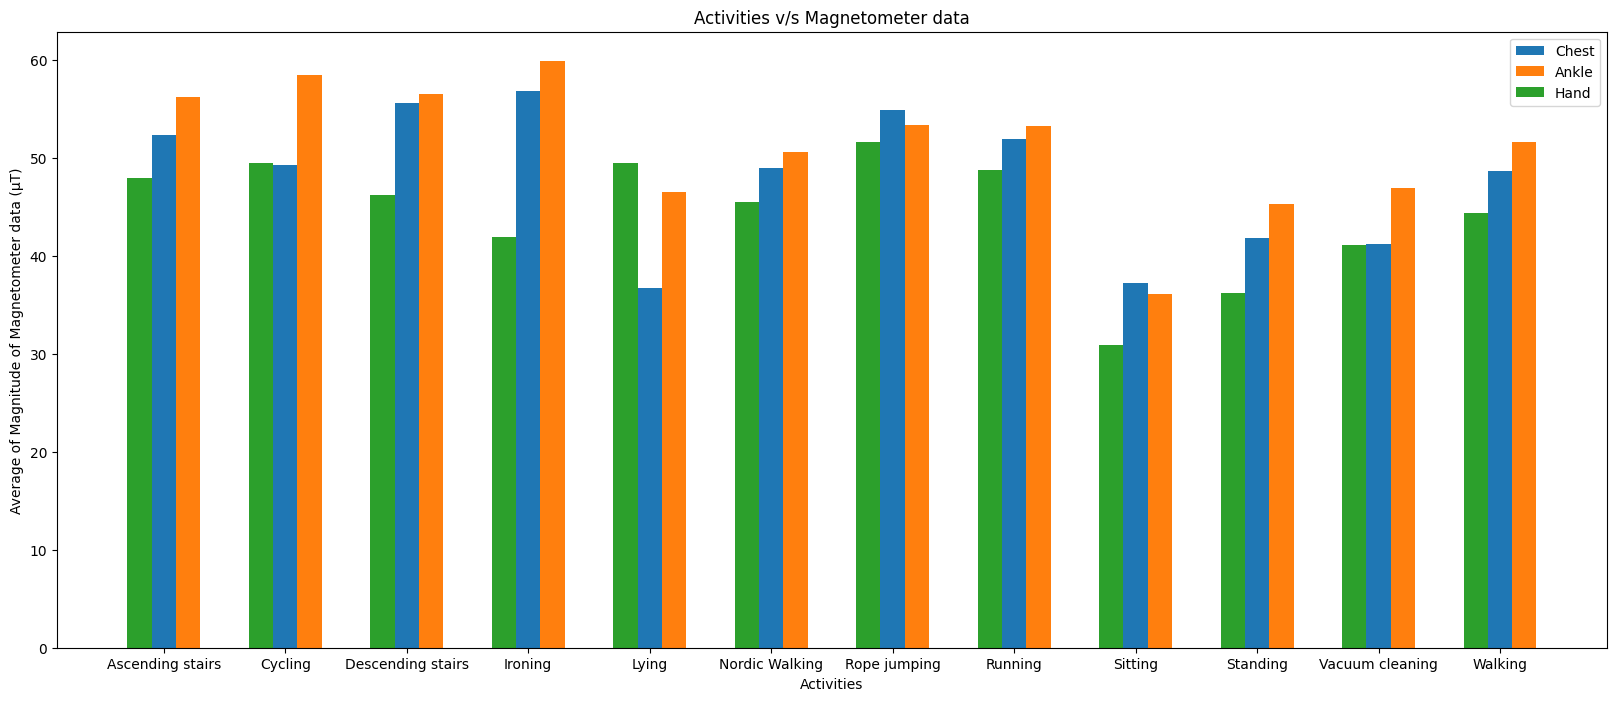

In [ ]:
x_MagHand = X_train['IMUhand_magX']
y_MagHand = X_train['IMUhand_magY']
z_MagHand = X_train['IMUhand_magZ']
X_train['IMUhand_mag'] = np.sqrt(x_MagHand**2 + y_MagHand**2 + z_MagHand**2) 

x_MagChest = X_train['IMUchest_magX']
y_MagChest = X_train['IMUchest_magY']
z_MagChest = X_train['IMUchest_magZ']
X_train['IMUchest_mag'] = np.sqrt(x_MagChest**2 + y_MagChest**2 + z_MagChest**2) 

x_MagAnkle = X_train['IMUankle_magX']
y_MagAnkle = X_train['IMUankle_magY']
z_MagAnkle = X_train['IMUankle_magZ']
X_train['IMUankle_mag'] = np.sqrt(x_MagAnkle**2 + y_MagAnkle**2 + z_MagAnkle**2) 

groupedMagDF = X_train.groupby(['activity']).mean()[['IMUhand_mag', 'IMUchest_mag', 'IMUankle_mag']]
activities = groupedMagDF.index
x = np.arange(len(groupedMagDF))
ankle = groupedMagDF['IMUankle_mag'].values
chest = groupedMagDF['IMUchest_mag'].values
hand = groupedMagDF['IMUhand_mag'].values
plt.figure(figsize=(20,8))
plt.title("Activities v/s Magnetometer data")

plt.bar(x, ankle, width, label = "Ankle")
plt.bar(x+0.2, hand, width, label = "Hand")
plt.bar(x-0.2, chest, width, label = "Chest")
plt.xticks(x, activities)
plt.xlabel("Activities")
plt.legend(["Chest","Ankle", "Hand"])
plt.ylabel("Average of Magnitude of Magnetometer data (μT)")

## 3.12 What is the magnitude of magnetometer data subject with time?

The plots show the magnitude of magnetometer data for a single subject at different times. The x-axis represents the timestamp with resolution of 0.01 second, and the y-axis represents the magnitude of magnetometer data. This plot can be used to see how the magnitude of magnetometer data changes over time for a single subject and to identify any patterns or trends in the data.

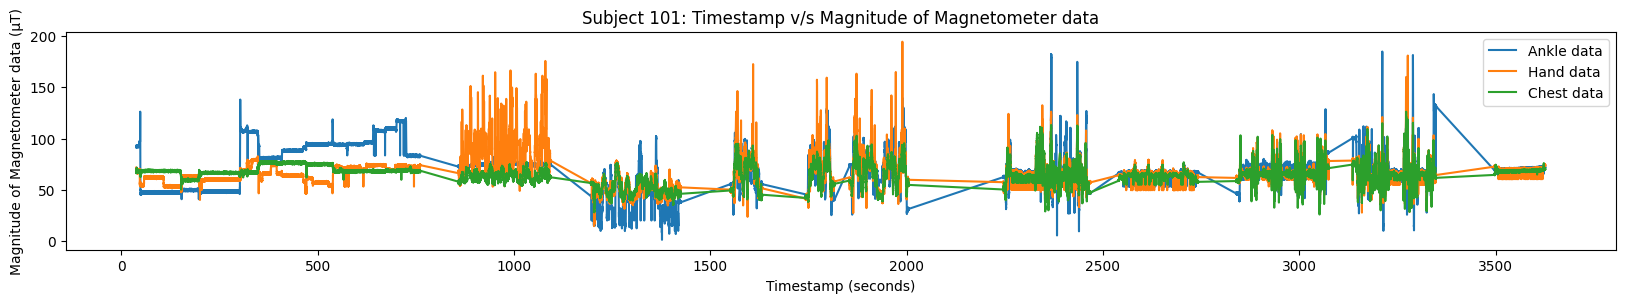

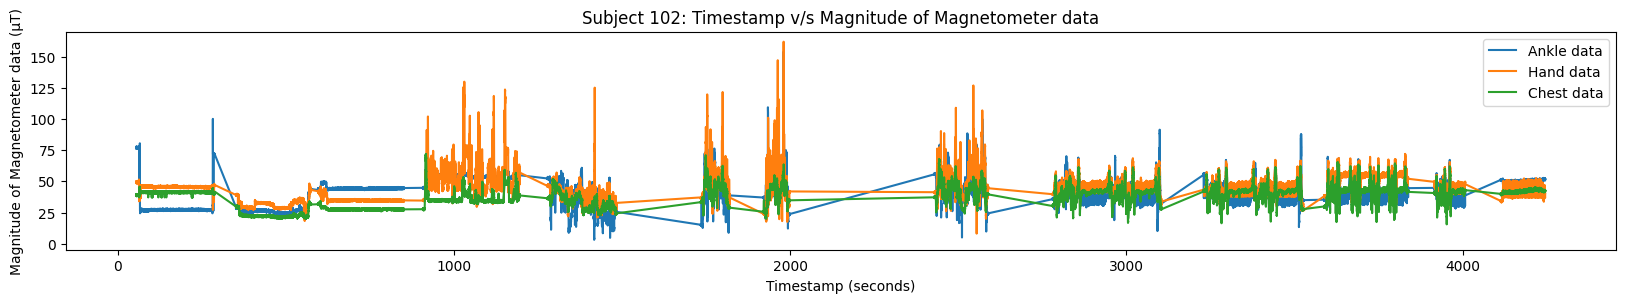

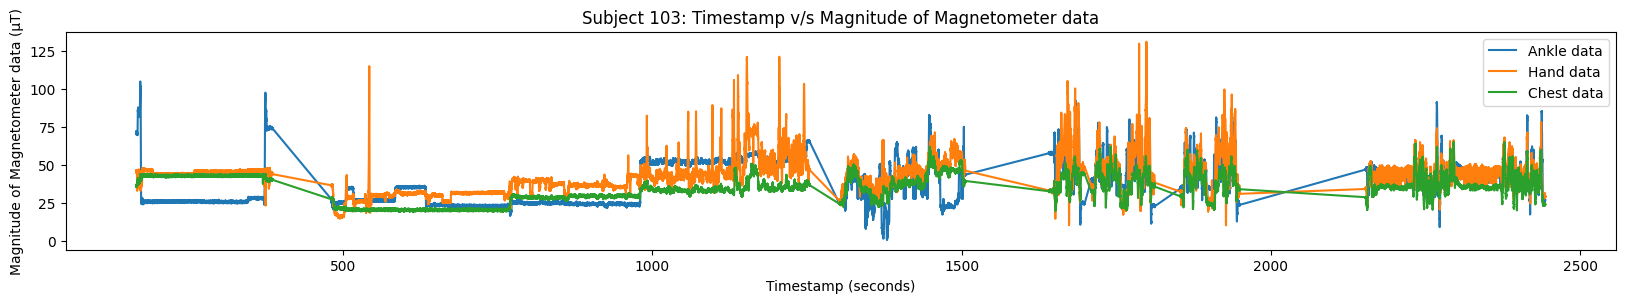

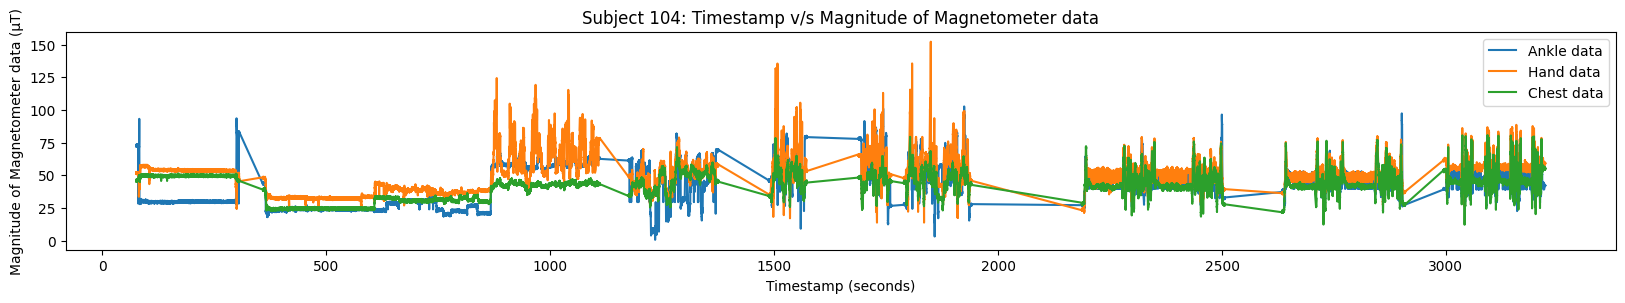

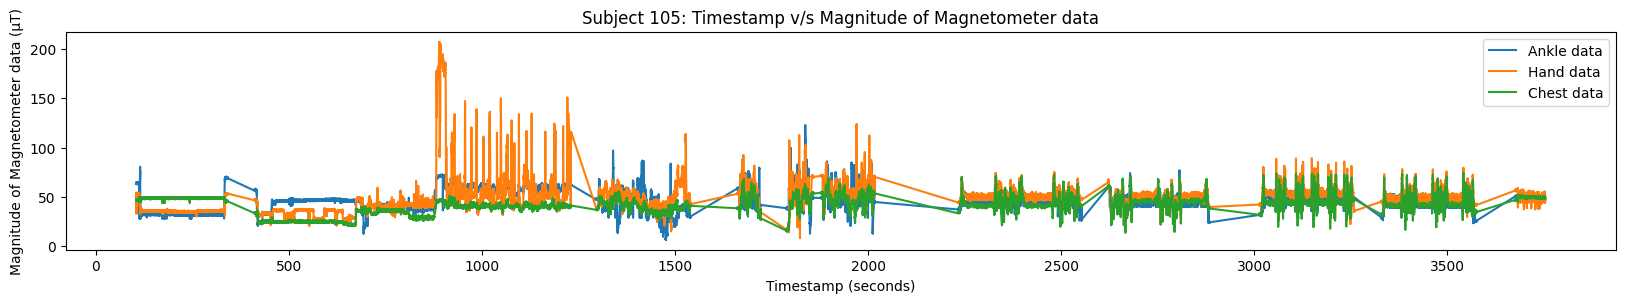

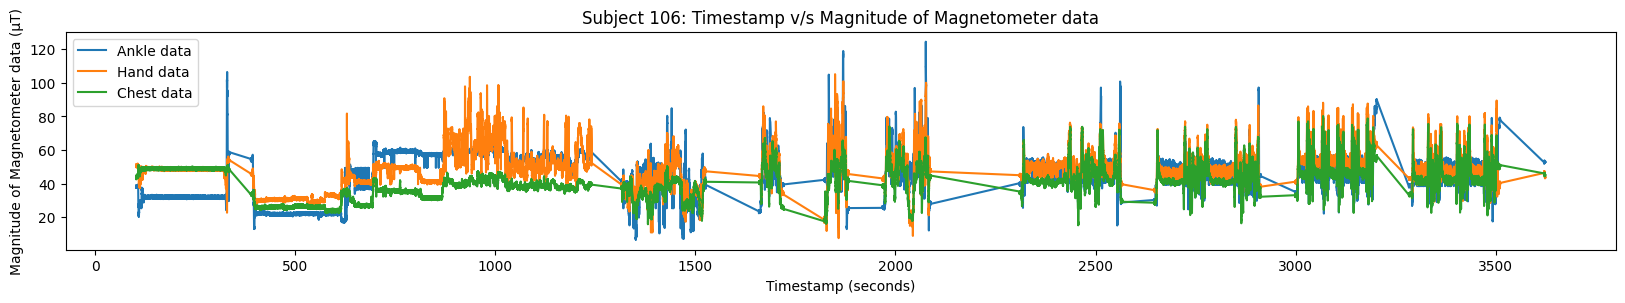

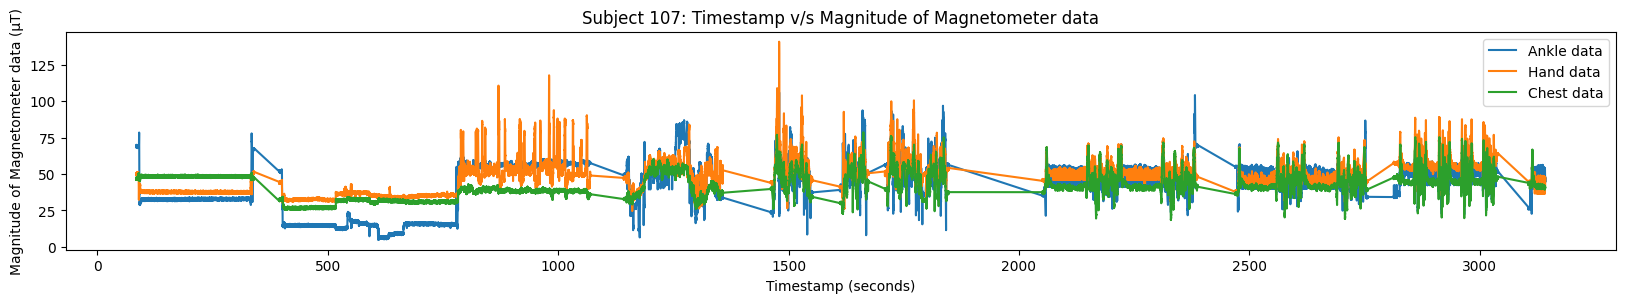

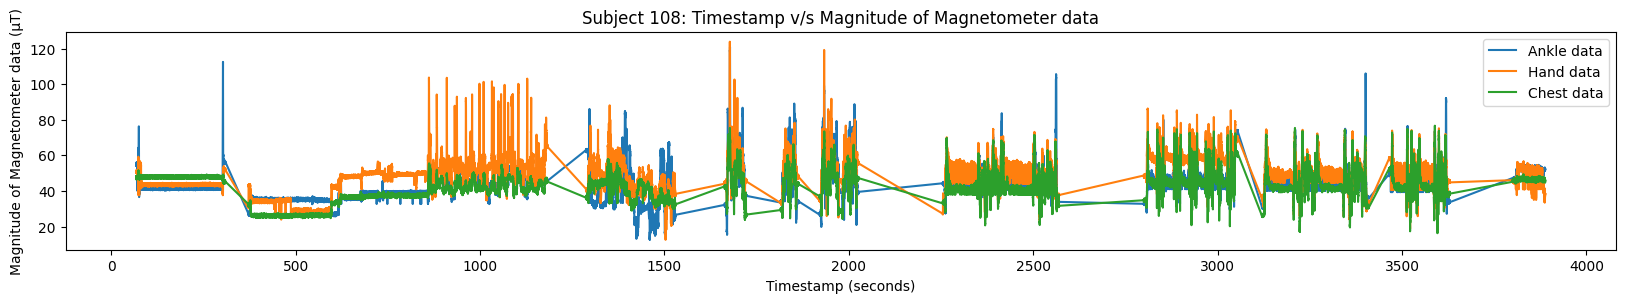

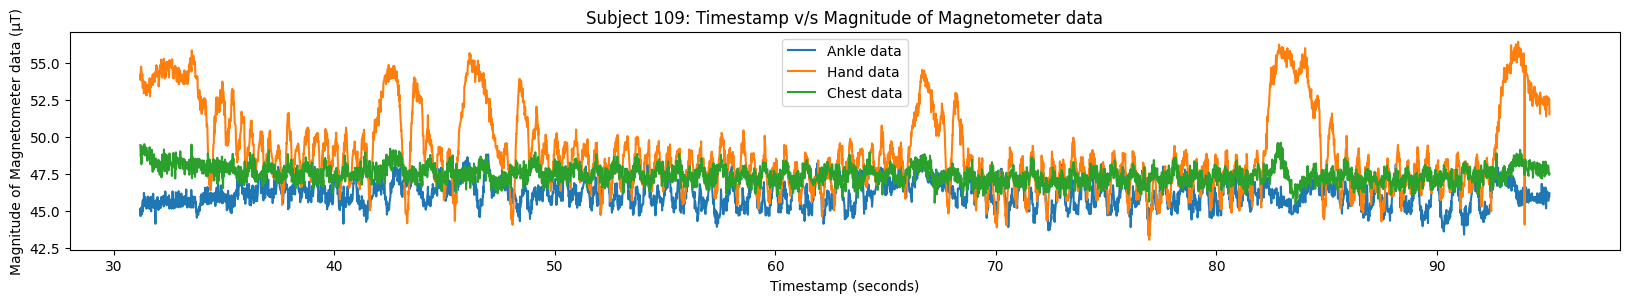

In [ ]:
for i in range(1,10):
  magAnkle = X_train[X_train['subject no.'] == i]['IMUankle_mag']
  magHand = X_train[X_train['subject no.'] == i]['IMUhand_mag']
  magChest = X_train[X_train['subject no.'] == i]['IMUchest_mag']
  timestamp = X_train[X_train['subject no.'] == i]['timestamp']
  plt.figure(figsize = (20,30))
  plt.subplot(9, 1, i)
  plt.title("Subject 10"+ str(i)+": Timestamp v/s Magnitude of Magnetometer data")
  plt.plot(timestamp, magAnkle, label = "Ankle data")
  plt.plot(timestamp, magHand, label = "Hand data")
  plt.plot(timestamp, magChest, label = "Chest data")
  plt.legend()
  plt.xlabel("Timestamp (seconds)")
  plt.ylabel("Magnitude of Magnetometer data (μT)")

# 4. Hypothesis Testing 

A hypothesis is an assumption or prediction about the relationship between variables that can be tested using statistical methods. In hypothesis testing, we start with a null hypothesis, which is a statement that there is no difference between the groups being compared. We then collect data and perform a statistical test to determine whether the null hypothesis can be rejected based on the data.

## 4.1 Average Duration of Activities

Natural Language: If average heartrate of fast activities is greater than that of slow activities then, average duration of fast activities must be less than average duration of slow activities.
Therefore,

null hypothesis, H0 : μA - μB = 0

alternative hypothesis, H1 : μA - μB > 0

where, μA is the average of duration of slow activities and μB is the average of duration of fast activities.


This hypothesis based on an assumption that activities that are physically demanding such as running, rope jumping are performed for less period of time than activities such as lying, sitting.

To test the hypothesis that the average heartrate of fast activities is greater than that of slow activities, and that the average duration of fast activities is less than the average duration of slow activities, we first need to split the duration training set into slow and fast activities. We do this based on the average heartrate for each activity. The first six activities from section 3.3 are grouped as fast activities and the rest of them are considered slow activities.

In [ ]:
slowActivities = xTrainDuration[(xTrainDuration['activity'] == 'Lying') | (xTrainDuration['activity'] == 'Sitting') | (xTrainDuration['activity'] == 'Standing') | (xTrainDuration['activity'] == 'Ironing') | (xTrainDuration['activity'] == 'Vacuum cleaning') | (xTrainDuration['activity'] == 'Walking')]
fastActivities = xTrainDuration[(xTrainDuration['activity'] == 'Rope jumping') | (xTrainDuration['activity'] == 'Ascending stairs') | (xTrainDuration['activity'] == 'Descending stairs') | (xTrainDuration['activity'] == 'Nordic Walking') | (xTrainDuration['activity'] == 'Running') | (xTrainDuration['activity'] == 'Cycling') ] 

We create a sample of 40 from each group, then find variance ratio of duration to check for equality in variance and perform t-test between the duration of both groups and whether the p-value obtained is statistically significant.

In [ ]:
sampleSlow = slowActivities.sample(n=40, random_state = 2)
sampleFast = fastActivities.sample(n=40, random_state = 2)

In [ ]:
avgSlowHeartrate = sampleSlow['heartrate'].mean() 
avgFasteartrate = sampleFast['heartrate'].mean()
print(avgSlowHeartrate, avgFasteartrate)

92.07209726197858 133.9084631347679


In [ ]:
len(sampleSlow)

40

In [ ]:
len(sampleFast)

40

In [ ]:
varSlow = np.var(sampleSlow['duration']) 
varFast = np.var(sampleFast['duration'])
print(varSlow, varFast)

4457.5986309374985 560560.5954694377


In [ ]:
ratio = varFast/varSlow

In [ ]:
ratio

125.753941052235

In [ ]:
st.ttest_ind(a=sampleSlow['duration'], b=sampleFast['duration'], equal_var=False)

Ttest_indResult(statistic=-1.4666309259121653, pvalue=0.1503694875324624)

Here, the p-value >= 0.05, hence we fail to reject the null hypothesis H0 of this test and hence, don’t have enough evidence to support the hypothesis that average duration of slow activities is more than average duration of fast activities.

## 4.2 Average of magnitude (ankle) of Gyroscope data

Natural Language: if average of magnitude of ankle accelerometer of fast activities is greater than average of magnitude of ankle accelerometer of slow activities then, average of magnitude of ankle gyroscope of fast activities must be greater than average magnitude of ankle gyroscope of slow activities.
Therefore,

null hypothesis, H0 : μA - μB = 0

alternative hypothesis, H1 : μA - μB > 0

where, μA is the average of magnitude of ankle gyroscope of fast activities and μB is the average magnitude of ankle gyroscope of slow activities.


In [ ]:
slowActivities = X_train[(X_train['activity'] == 'Lying') | (X_train['activity'] == 'Sitting') | (X_train['activity'] == 'Standing') | (X_train['activity'] == 'Ironing') | (X_train['activity'] == 'Vacuum cleaning') | (X_train['activity'] == 'Walking')]
fastActivities = X_train[(X_train['activity'] == 'Rope jumping') | (X_train['activity'] == 'Ascending stairs') | (X_train['activity'] == 'Descending stairs') | (X_train['activity'] == 'Nordic Walking') | (X_train['activity'] == 'Running') | (X_train['activity'] == 'Cycling') ] 

In [ ]:
sampleSlow = slowActivities.sample(n=40, random_state = 2)
sampleFast = fastActivities.sample(n=40, random_state = 2)

In [ ]:
avgSlowAcc = sampleSlow['IMUankle_acc16'].mean()
avgFastAcc = sampleFast['IMUankle_acc16'].mean()
print(avgSlowAcc, avgFastAcc)

12.928940159622835 15.66640003516


if average of magnitude of ankle accelerometer of fast activities is greater than average of magnitude of ankle accelerometer of slow activities then, average of magnitude of ankle gyroscope of fast activities must be greater than average magnitude of ankle gyroscope of slow activities.

In [ ]:
varSlow = np.var(sampleSlow['IMUankle_gyro']) 
varFast = np.var(sampleFast['IMUankle_gyro'])
print(varSlow, varFast)
ratio = varFast/varSlow
ratio

2.1469948275244444 5.6523502759129


2.6326799689733047

The ratio of variances of two sample is 2.6326799689733047, which is less than 4. This means we can assume that the population variances are equal. Hence, we perform two-sample test with equal variance.

Reference: https://www.geeksforgeeks.org/how-to-conduct-a-two-sample-t-test-in-python/

In [ ]:
st.ttest_ind(a=sampleSlow['IMUankle_gyro'], b=sampleFast['IMUankle_gyro'], equal_var=True)

Ttest_indResult(statistic=-5.4588872655442815, pvalue=5.496990437979385e-07)

Here, the pvalue < 0.05, hence we  reject the null hypothesis H0 of this test and hence, support the hypothesis that average of magnitude of ankle gyroscope of fast activities is greater than average magnitude of ankle gyroscope of slow activities.

## 4.3 Average of magnitude (ankle) of Magnetometer

Natural Language: if average of magnitude of ankle accelerometer of fast activities is greater than average of magnitude of ankle accelerometer of slow activities then, average of magnitude of ankle magnetometer of fast activities must be greater than average magnitude of ankle magnetometer of slow activities.
Therefore,

null hypothesis, H0 : μA - μB = 0

alternative hypothesis, H1 : μA - μB > 0

where, μA is the average of magnitude of ankle magnetometer of fast activities and μB is the average magnitude of ankle magnetometer of slow activities.


In [ ]:
slowActivities = X_train[(X_train['activity'] == 'Lying') | (X_train['activity'] == 'Sitting') | (X_train['activity'] == 'Standing') | (X_train['activity'] == 'Ironing') | (X_train['activity'] == 'Vacuum cleaning') | (X_train['activity'] == 'Walking')]
fastActivities = X_train[(X_train['activity'] == 'Rope jumping') | (X_train['activity'] == 'Ascending stairs') | (X_train['activity'] == 'Descending stairs') | (X_train['activity'] == 'Nordic Walking') | (X_train['activity'] == 'Running') | (X_train['activity'] == 'Cycling') ] 

In [ ]:
sampleSlow = slowActivities.sample(n=40, random_state = 2)
sampleFast = fastActivities.sample(n=40, random_state = 2)

In [ ]:
avgSlowAcc = sampleSlow['IMUankle_acc16'].mean()
avgFastAcc = sampleFast['IMUankle_acc16'].mean()
print(avgSlowAcc, avgFastAcc)

12.928940159622835 15.66640003516


In [ ]:
varSlow = np.var(sampleSlow['IMUankle_mag']) 
varFast = np.var(sampleFast['IMUankle_mag'])
print(varSlow, varFast)
ratio = varSlow/varFast
ratio

335.4701126411304 190.99104551057889


1.7564703713952334

The ratio of variances of two sample is 1.7564703713952334, which is less than 4. This means we can assume that the population variances are equal. Hence, we perform two-sample test with equal variance.

In [ ]:
st.ttest_ind(a=sampleSlow['IMUankle_mag'], b=sampleFast['IMUankle_mag'], equal_var=True)

Ttest_indResult(statistic=-1.1178819891804839, pvalue=0.2670486798389141)

Here, the pvalue >= 0.05, hence we fail to reject the null hypothesis H0 of this test and hence,don’t have enough evidence to support the hypothesis that average of magnitude of ankle magnetometer of fast activities is greater than average magnitude of ankle magnetometer of slow activities.

# 5. Machine Learning 

## 5.1 Dimensionality Reduction (PCA)

Principal Component Analysis (PCA) is a technique for dimensionality reduction in machine learning. It is a linear transformation that is used to identify the underlying structure in a set of data by finding the directions (principal components) that capture the most variance in the data. Here, we use sci-kit library’s PCA method to perform dimensionality reduction on the training set. We use the transformed training set to predict output.

In [ ]:
# preparing training set
removeColumns = [ 'activityID','subject no.', 'activity', 'IMUhand_acc16',
       'IMUchest_acc16', 'IMUankle_acc16', 'IMUhand_gyro', 'IMUchest_gyro',
       'IMUankle_gyro', 'IMUhand_mag', 'IMUchest_mag', 'IMUankle_mag']
y_train = X_train['activity']
y_trainID = X_train['activityID']
X_train.drop(columns = removeColumns, inplace=True)


In [ ]:
X_test.isnull().sum()

timestamp                    0
activityID                   0
heartrate               783188
IMUhand_temperature       3947
IMUhand_acc16X            3947
IMUhand_acc16Y            3947
IMUhand_acc16Z            3947
IMUhand_gyroX             3947
IMUhand_gyroY             3947
IMUhand_gyroZ             3947
IMUhand_magX              3947
IMUhand_magY              3947
IMUhand_magZ              3947
IMUchest_temperature      1093
IMUchest_acc16X           1093
IMUchest_acc16Y           1093
IMUchest_acc16Z           1093
IMUchest_gyroX            1093
IMUchest_gyroY            1093
IMUchest_gyroZ            1093
IMUchest_magX             1093
IMUchest_magY             1093
IMUchest_magZ             1093
IMUankle_temperature      3528
IMUankle_acc16X           3528
IMUankle_acc16Y           3528
IMUankle_acc16Z           3528
IMUankle_gyroX            3528
IMUankle_gyroY            3528
IMUankle_gyroZ            3528
IMUankle_magX             3528
IMUankle_magY             3528
IMUankle

In [ ]:
# preparing x and y test sets
xTestIndices = getSessionIndices(X_test)
fillNullWithMean(X_test, xTestIndices)
X_test.drop(X_test[X_test['activityID'] == 0].index, inplace = True)
X_test.reset_index(drop=True, inplace=True)
y_test = X_test['activity']
y_testID = X_test['activityID']
X_test.drop(columns = [ 'activityID','subject no.', 'activity'], inplace=True)

In [ ]:
y_test

0                Lying
1                Lying
2                Lying
3                Lying
4                Lying
              ...     
582608    Rope jumping
582609    Rope jumping
582610    Rope jumping
582611    Rope jumping
582612    Rope jumping
Name: activity, Length: 582613, dtype: object

In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582613 entries, 0 to 582612
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   timestamp             582613 non-null  float64
 1   heartrate             582613 non-null  float64
 2   IMUhand_temperature   582613 non-null  float64
 3   IMUhand_acc16X        582613 non-null  float64
 4   IMUhand_acc16Y        582613 non-null  float64
 5   IMUhand_acc16Z        582613 non-null  float64
 6   IMUhand_gyroX         582613 non-null  float64
 7   IMUhand_gyroY         582613 non-null  float64
 8   IMUhand_gyroZ         582613 non-null  float64
 9   IMUhand_magX          582613 non-null  float64
 10  IMUhand_magY          582613 non-null  float64
 11  IMUhand_magZ          582613 non-null  float64
 12  IMUchest_temperature  582613 non-null  float64
 13  IMUchest_acc16X       582613 non-null  float64
 14  IMUchest_acc16Y       582613 non-null  float64
 15  

In [ ]:
#performing PCA with number of features we want
pca = PCA(n_components = 10, random_state=42)
# fitting and transforming training data 
X_trainPCA = pca.fit_transform(X_train)
# transforming testing set
X_testPCA = pca.transform(X_test)
  
explained_variance = pca.explained_variance_ratio_

## 5.2 Modelling

i.	Logistic Regression

In logistic regression, the goal is to predict the probability that an input belongs to a certain class. The model does this by using a logistic function to map the input to a probability between 0 and 1. The predicted probability can then be used to assign the input to a class, based on a threshold (usually 0.5). When the number of classes are 2, the logistic function is sigmoid while for more classes the function becomes SoftMax.


We chose logistic regression because:

o	It is fast and efficient. It can handle large datasets and produce accurate results in a relatively short amount of time.

o	It is interpretable. The coefficients of the model can be used to understand how much each feature contributes to the outcome, which can be useful for understanding the underlying patterns in the data.

o	It can be used to make predictions in real-time. We can use the trained model to make predictions on new data as it becomes available, which makes it well-suited for use in applications where timely decisions are important.


In [ ]:
import random
# class for Logistic Regression
class LogisticRegression:

    # constructor of the class
    def __init__(self, learning_rate=0.01, num_iterations=1000, num_classes=2):
        # initialising necessary variables
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.num_classes = num_classes
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        #print("train")
        # fit method to train model on data
        num_samples, num_features = X.shape
        # initialising weights and bias to arrays of random numbers
        self.weights = np.random.random((num_features, self.num_classes))
        #print("weights", self.weights)
        self.bias = np.random.random(self.num_classes)
        #print("bias",self.bias)
        for i in range(self.num_iterations):
            z = np.dot(X, self.weights) + self.bias
            # predicting class
            y_pred = self._softmax(z)

            # small changes to update on weights and bias
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y, axis=0)

            # updating weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            #print(self.weights, self.bias)

    def predict(self, X):
        #print("test")
        # predict method to predict on data
        z = np.dot(X, self.weights) + self.bias
        #print(z)
        y_pred = self._softmax(z)
        # return the index of class
        #print(y_pred)
        y_pred_cls = np.argmax(y_pred, axis=1)
        return y_pred_cls

    def _softmax(self, z):
        # private method for multi-class classification
        # to be only called by methods inside this class
        exp_z = np.exp(z)
        return (exp_z / np.sum(exp_z, axis=1, keepdims=True))

To use this class, we would first create an instance of it, passing in any desired hyperparameters (such as the learning rate and number of iterations) and the number of classes. Then, we call the fit method on our training data to train the model. Finally, we use the predict method to make predictions on test data.

The labels for activities should be one-hot encoded, meaning that they should be represented as a matrix with one column for each class and a row for each sample, with a 1 in the column corresponding to the class label and 0s in all other columns. 

In [ ]:
y_trainNew = y_train.to_numpy()
oe = OneHotEncoder()
y_trainReshaped = y_trainNew.reshape(-1,1) 
y_train_enc = oe.fit_transform(y_trainReshaped)

In [ ]:
y_testReshaped = y_test.to_numpy().reshape(-1, 1)
y_test_enc = oe.transform(y_testReshaped) 
y_test_enc

<582613x12 sparse matrix of type '<class 'numpy.float64'>'
	with 582613 stored elements in Compressed Sparse Row format>

In [ ]:

# create an instance of the LogisticRegression class with 3 classes
logistic_regression = LogisticRegression(learning_rate=100, num_iterations=0, num_classes=len(y_train.unique()))
# train the model on the training data
logistic_regression.fit(X_trainPCA, y_train_enc.toarray())
y_trainPCA = logistic_regression.predict(X_trainPCA)
#trainPreidctedLabels = getLabels(y_trainPCA)
# make predictions on the test data
y_testPCA = logistic_regression.predict(X_testPCA)
#testPredictedLabels = getLabels(y_testPCA)
 

In [ ]:
# get activity labels of indices of activity categories predicted by the model
def getLabels(yIndices):
    predictedLabels = []
    for index in yIndices:
        predictedLabels.append(oe.categories_[0][index])
    return predictedLabels
trainPredictedLabels  = getLabels(y_trainPCA)
testPredictedLabels = getLabels(y_testPCA)

In [ ]:
# performance on training set
print(classification_report(y_train, trainPredictedLabels))

                   precision    recall  f1-score   support

 Ascending stairs       0.00      0.00      0.00     81862
          Cycling       0.00      0.00      0.00    115367
Descending stairs       0.11      0.00      0.00     73357
          Ironing       0.00      0.00      0.00    167095
            Lying       0.00      0.00      0.00    134926
   Nordic Walking       0.00      0.00      0.00    131652
     Rope jumping       0.00      0.00      0.00     34489
          Running       0.00      0.00      0.00     68751
          Sitting       0.00      0.00      0.00    129608
         Standing       0.00      0.00      0.00    133211
  Vacuum cleaning       0.00      0.00      0.00    122762
          Walking       0.70      0.86      0.77    167178

         accuracy                           0.11   1360258
        macro avg       0.07      0.07      0.06   1360258
     weighted avg       0.09      0.11      0.10   1360258



In [ ]:
# performance on testing set
print(classification_report(y_test, testPredictedLabels))

                   precision    recall  f1-score   support

 Ascending stairs       0.00      0.00      0.00     35354
          Cycling       0.00      0.00      0.00     49233
Descending stairs       0.10      0.00      0.00     31587
          Ironing       0.00      0.00      0.00     71595
            Lying       0.00      0.00      0.00     57597
   Nordic Walking       0.00      0.00      0.00     56455
     Rope jumping       0.00      0.00      0.00     14871
          Running       0.00      0.00      0.00     29447
          Sitting       0.00      0.00      0.00     55580
         Standing       0.00      0.00      0.00     56720
  Vacuum cleaning       0.00      0.00      0.00     52591
          Walking       0.70      0.86      0.77     71583

         accuracy                           0.11    582613
        macro avg       0.07      0.07      0.06    582613
     weighted avg       0.09      0.11      0.09    582613



We see the results, the f1-score and accuracy,  given out by Logistic regression are poor. This is because Logistic regression is a linear model, which means it can only capture linear relationships between the independent variables and the outcome. If the relationships in the data are more complex, a linear model may not be able to capture them accurately and may not perform well, even with number of dimensions reduced.

## ii.	1D Convolutional Neural Network

1-Dimensional CNNs are like traditional CNNs in that they are composed of multiple interconnected layers, including convolutional layers, pooling layers, and fully connected layers. However, the convolutional layers in a 1D CNN operate on one-dimensional input data rather than two-dimensional images. This means that the filters used in the convolutional layers have a smaller spatial extent and are applied along 1 dimension of the data.

We choose 1D CNN because:
1D CNNs are able to learn features from the data that are relevant to the task. They can automatically extract features from the input data that are useful for distinguishing between different types of activities, which can be useful for improving the accuracy of the model.

o	1D CNNs can capture temporal dependencies in the data. Human activities often involve patterns of movement over time, and a 1D CNN can capture these patterns and use them to make predictions.

o	They are fast and efficient. They can handle large datasets and can produce accurate results in a relatively short amount of time.

o	They are robust to noise and can handle missing data. They can still produce reliable results even when some of the data is noisy or missing, which is often the case with data from wearable devices.

o	They can be used to make predictions in real-time. We can use the trained model to make predictions on new data as it becomes available, which makes it well-suited for use in applications where timely decisions are important.


In [ ]:
X_trainNew = X_train.to_numpy().reshape(X_train.to_numpy().shape[0],X_train.to_numpy().shape[1],1)

In [ ]:
X_trainNew

array([[[ 37.66      ],
        [ 87.6407932 ],
        [ 30.375     ],
        ...,
        [-61.1081    ],
        [-36.8636    ],
        [-58.3696    ]],

       [[ 37.67      ],
        [ 87.6407932 ],
        [ 30.375     ],
        ...,
        [-60.8916    ],
        [-36.3197    ],
        [-58.3656    ]],

       [[ 37.68      ],
        [ 87.6407932 ],
        [ 30.375     ],
        ...,
        [-60.3407    ],
        [-35.7842    ],
        [-58.6119    ]],

       ...,

       [[ 95.07      ],
        [148.50510204],
        [ 25.125     ],
        ...,
        [-46.0331    ],
        [ -0.817288  ],
        [  0.538134  ]],

       [[ 95.09      ],
        [162.        ],
        [ 25.125     ],
        ...,
        [-45.9093    ],
        [ -0.565555  ],
        [  0.680109  ]],

       [[ 95.1       ],
        [148.50510204],
        [ 25.125     ],
        ...,
        [-46.1702    ],
        [ -0.812965  ],
        [ -0.313346  ]]])

In [ ]:
X_testNew = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# defining the architecture of the model
# using relu activation function
# and finally using softmax for multiple classification
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32,1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(12, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-01-02 20:08:55.466978: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (100)
2023-01-02 20:08:55.467974: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Namrata): /proc/driver/nvidia/version does not exist
2023-01-02 20:08:55.471092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Once our model architecture is defined, we compile it and specify the loss function and optimization algorithm to use. We then use the fit() method to train our model on the training data. As the model trains, it will update the weights of the layers to minimize the loss function.


In [ ]:
# the training takes about 22 mins 
 
verbose, epochs, batch_size = 0, 10, 32
model.fit(X_trainNew, y_train_enc.toarray(), epochs=epochs, batch_size=batch_size, verbose=verbose)



After training is complete, we use the model to make predictions on new data. We then evaluate the model and predict the test data. 


In [ ]:
#model.save("models/cnn")

In [ ]:
#model.load_weights('models/cnn')

2023-01-02 20:08:58.939747: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/cnn: FAILED_PRECONDITION: models/cnn; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [ ]:
_, accuracyTrain = model.evaluate(X_trainNew, y_train_enc.toarray(), batch_size=32, verbose=0)
_, accuracyTest = model.evaluate(X_testNew, y_test_enc.toarray(), batch_size=32, verbose=0)

In [ ]:
# training accuracy
accuracyTrain

0.9288392066955566

In [ ]:
# training accuracy
accuracyTest

0.9290558099746704

In [ ]:
y_pred_test = model.predict(X_testNew)

18207/18207 [==============================] - 29s 2ms/step


In [ ]:
len(y_pred_test)

582613

In [ ]:
binaryVectors = []
for vec in y_pred_test:
  vector = [0]*len(vec)
  index = np.argmax(vec)
  vector[index] = 1
  binaryVectors.append(vector)

print(binaryVectors)
predictedLabels = oe.inverse_transform(binaryVectors)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
len(predictedLabels)

582613

In [ ]:
predictedLabels = oe.inverse_transform(binaryVectors)

In [ ]:
print(classification_report(y_test, predictedLabels))

                   precision    recall  f1-score   support

 Ascending stairs       0.78      0.98      0.87     35354
          Cycling       1.00      0.85      0.92     49233
Descending stairs       0.70      0.97      0.82     31587
          Ironing       0.99      0.99      0.99     71595
            Lying       1.00      1.00      1.00     57597
   Nordic Walking       0.99      0.62      0.76     56455
     Rope jumping       1.00      0.98      0.99     14871
          Running       1.00      0.91      0.95     29447
          Sitting       1.00      0.99      0.99     55580
         Standing       0.98      0.99      0.99     56720
  Vacuum cleaning       1.00      1.00      1.00     52591
          Walking       0.80      0.92      0.86     71583

         accuracy                           0.93    582613
        macro avg       0.94      0.93      0.93    582613
     weighted avg       0.94      0.93      0.93    582613



1D CNN work have high accuracy and f1-score as it is able to capture complex relations between variables unlike, logistic regression.

## 5.3 Finding Duration

We find duration by dividing test samples to sessions by calculating differences in heart rate. If change in current heartrate and next heart rate is more than 15, the session changes. And using the respective ending and starting timestamps, we find duration.

In [ ]:
# function to find indices
def findStartandEnd(df):
  startIndex = 0
  indices = []
  for i in range(len(df['heartrate'])-1):
    if i == (len(df) - 1):
      endIndex = len(df)-1
      indices.append((startIndex, endIndex))
    # get current and next heartrate value
    currentValue = df['heartrate'][i]
    nextValue = df['heartrate'][i+1]
    diff = abs(nextValue-currentValue)
    # check if difference is more than equal to 15
    if diff >= 15:
      # re-assign ending index to current index
      endIndex = i
      # append indices
      indices.append((startIndex, endIndex))
      # re-assign staring index to next index
      startIndex = i+1
  # return tuple of indices
  return indices

In [ ]:
durationIndices = findStartandEnd(X_test)

In [ ]:
len(predictedLabels)

582613

In [ ]:
len(durationIndices)

9979

In [ ]:
data = pd.DataFrame()
data['timestamp'] = X_test['timestamp']
data['activity_predicted'] = predictedLabels

In [ ]:
data

,timestamp,activity_predicted
0,37.70,Lying
1,37.71,Lying
2,37.72,Lying
3,37.74,Lying
4,37.76,Lying
...,...,...
582608,95.01,Rope jumping
582609,95.03,Rope jumping
582610,95.04,Rope jumping
582611,95.06,Rope jumping


In [ ]:
# predicted activities with duration 
for lst in durationIndices[50:100]:
  start = lst[0]
  end = lst[1]+1
  duration = X_test['timestamp'][end] - X_test['timestamp'][start]
  print("---Duration in seconds",duration) 
  print(data[['timestamp', 'activity_predicted']][start: end+1])
  print()

---Duration in seconds 0.8599999999999994
     timestamp activity_predicted
612      56.97              Lying
613      57.03              Lying
614      57.08              Lying
615      57.14              Lying
616      57.23              Lying
617      57.26              Lying
618      57.27              Lying
619      57.29              Lying
620      57.35              Lying
621      57.37              Lying
622      57.38              Lying
623      57.44              Lying
624      57.48              Lying
625      57.52              Lying
626      57.56              Lying
627      57.58              Lying
628      57.62              Lying
629      57.63              Lying
630      57.71              Lying
631      57.77              Lying
632      57.83              Lying

---Duration in seconds 0.010000000000005116
     timestamp activity_predicted
632      57.83              Lying
633      57.84              Lying

---Duration in seconds 0.5399999999999991
     timestamp activ

## 6. Conclusion

Human activity recognition using 1D CNN has shown to be a promising approach for identifying and classifying human activities using ankle, chest, and hand sensors’ data along with heartrate. This model gives accuracy score of 92.88% on training set and 92.90% on testing set. We have also performed data manipulation, EDA, and hypothesis testing. Some conclusions to draw from EDA and hypothesis testing:

o	Running, Ascending stairs, and Rope jumping are the top 3 activities with the highest average heartrate.

o	Average duration for rope jumping is the highest of all. After which, far from rope jumping, cycling and walking have second and third highest average duration.

o	The average magnitude of acceleration is highest for running, rope jumping, and Nordic walking.

o	Average magnitude of fast activities need not be greater than average magnitude of slow activities.

